### IMPORTS

In [1]:
%pip install sqlalchemy psycopg2-binary pandas python-dotenv "elasticsearch==8.7.0"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install sentence-transformers
from elasticsearch import Elasticsearch
import pandas as pd
from sentence_transformers import SentenceTransformer
import json
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
import warnings
warnings.filterwarnings("ignore")

### Funcionalidades

Nuestro sistema es capaz de gestionar las siguientes funcionalidades:
- Tendencias en los videos
- Tendencias en los comentarios
- Búsqueda de videos similares
- Búsqueda de comentarios similares 
- Búsqueda de comentarios positivos dado un tema
- Búsqueda de comentarios duplicados
- Exporación de DBPEDIA
- Exploración de Wikidata
- Comparación de consultas tipo OLTP
- Consultas enlazadas con wikidata


#### Tendencias
Gracias a los datos que hemos almacenado en el sistema, es posible obtener:
- Las tendencias de likes por visitas de los videos de cada canal junto con la duración de los vídeos de cada canal.
- Las franjas horarias en las cuales es mejor publicar videos.
- Las épocas del año en las cuales es mejor publicar videos ya que se obtiene unas mejores métricas. 
- Los canales con una tendencia de comentarios positivos.

In [4]:

import os
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from typing import Optional


# --- Config DB ---
DB_HOST = os.getenv("PGHOST", "postgres")  
DB_PORT = int(os.getenv("PGPORT", "5432"))
DB_NAME = os.getenv("PGDATABASE", "bbdd_api_youtube")
DB_USER = os.getenv("PGUSER", "postgres")
DB_PASS = os.getenv("PGPASSWORD", "postgres")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

def run_query(sql: str, params: Optional[dict] = None) -> pd.DataFrame:
    with engine.connect() as conn:
        df = pd.read_sql(text(sql), conn, params=params)
    return df

print(f"Conectando a {DB_NAME}@{DB_HOST}:{DB_PORT} como {DB_USER} ... listo.")


Conectando a bbdd_api_youtube@postgres:5432 como postgres ... listo.


**Tendencias de los vídeos**

Filas: 7


,channel,avg_dur_min,avg_likes,avg_comments,ratio_likes,ratio_comments
0,Mathologer,24.46,15846.13,1484.18,0.001544,0.016480
1,El Traductor de Ingeniería,22.29,16791.13,514.00,0.001327,0.043366
2,3Blue1Brown,15.01,95621.25,2191.34,0.000157,0.006850
3,QuantumFracture,10.99,76055.05,1890.27,0.000145,0.005814
4,Veritasium,10.96,206185.49,10329.51,0.000053,0.001061
5,ElectroBOOM,7.97,155205.37,3774.71,0.000051,0.002111
6,BBC Timestamp,6.61,2024.00,187.19,0.003266,0.035312


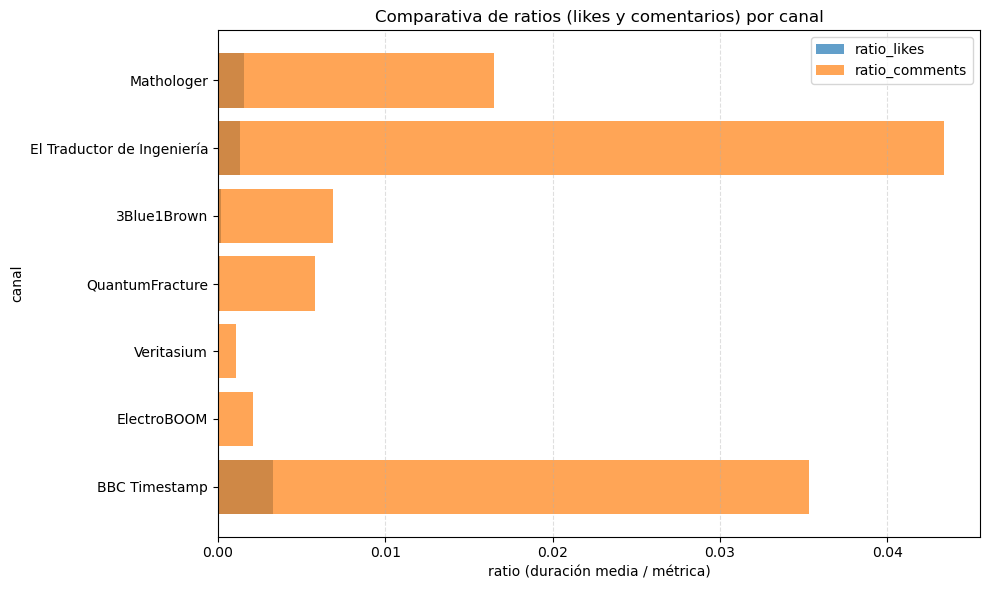

In [5]:

sql_1 = """
-- con los ratios de comments y likes por duración de video
WITH per_channel_base AS (
  SELECT
    c.name AS channel,
    ROUND((AVG(v.duration)::float / 60.0)::numeric, 2) AS avg_dur_min,
    ROUND((AVG(v.like_count)::float)::numeric, 2)      AS avg_likes,
    ROUND((AVG(v.comment_count)::float)::numeric, 2)   AS avg_comments
  FROM public.video v
  JOIN public.channel c ON c.id = v.id_channel
  WHERE v.duration IS NOT NULL
    AND v.like_count IS NOT NULL
    AND v.comment_count IS NOT NULL
  GROUP BY c.name
),
per_channel AS (
  SELECT
    channel,
    avg_dur_min,
    avg_likes,
    avg_comments,
    avg_dur_min / NULLIF(avg_likes,0)    AS ratio_likes,
    avg_dur_min / NULLIF(avg_comments,0) AS ratio_comments
  FROM per_channel_base
)
SELECT *
FROM per_channel
ORDER BY avg_dur_min DESC;
"""
df_ratios = run_query(sql_1)
print("Filas:", len(df_ratios))
display(df_ratios.head(20))


df_top = df_ratios.sort_values("avg_dur_min", ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(df_top["channel"], df_top["ratio_likes"], color="#1f77b4", alpha=0.7, label="ratio_likes")
plt.barh(df_top["channel"], df_top["ratio_comments"], color="#ff7f0e", alpha=0.7, label="ratio_comments")

plt.title("Comparativa de ratios (likes y comentarios) por canal")
plt.xlabel("ratio (duración media / métrica)")
plt.ylabel("canal")
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


**Épocas del año en donde es mejor publicar**

Filas: 14


<Figure size 1000x500 with 0 Axes>

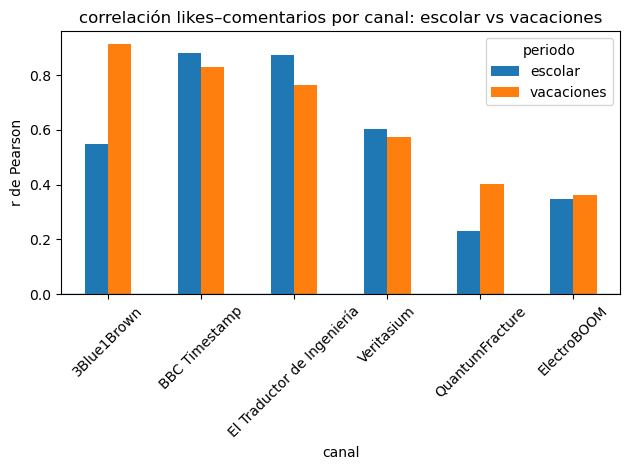

In [6]:

sql_2 = """
WITH base AS (
  SELECT
    c.name                       AS channel,
    v.like_count::float          AS likes,
    v.comment_count::float       AS comments,
    CASE
      WHEN EXTRACT(MONTH FROM v.published_at) IN (7,8) THEN 'vacaciones'
      ELSE 'escolar'
    END                          AS periodo
  FROM public.video v
  JOIN public.channel c ON c.id = v.id_channel
  WHERE v.like_count IS NOT NULL
    AND v.comment_count IS NOT NULL
    AND v.published_at IS NOT NULL
)
SELECT
  channel,
  periodo,
  ROUND((corr(likes, comments))::numeric,3)  AS r_pearson,
  COUNT(*)               AS n
FROM base
GROUP BY channel, periodo
HAVING COUNT(*) >= 5           -- mínimo tamaño muestral
ORDER BY channel, periodo;
"""
df_corr = run_query(sql_2)
print("Filas:", len(df_corr))


min_n = 20  
both = (df_corr
        .query("periodo in ['escolar','vacaciones']")
        .copy())

both = both[both["n"] >= min_n]

pv_r = (both
        .pivot_table(index="channel", columns="periodo", values="r_pearson", aggfunc="first")
        .dropna(subset=["escolar","vacaciones"])
        )

topN = 20
order_idx = (pv_r.abs().max(axis=1)).sort_values(ascending=False).index[:topN]
pv_top = pv_r.loc[order_idx]

plt.figure(figsize=(10,5))
pv_top.plot(kind="bar", rot=45)
plt.title("correlación likes–comentarios por canal: escolar vs vacaciones")
plt.xlabel("canal")
plt.ylabel("r de Pearson")
plt.axhline(0, linewidth=1)
plt.tight_layout()
plt.show()



**Mejores franjas horarias para publicar**

In [7]:
sql_franjas = """
WITH base AS (
  SELECT
    v.id,
    v.like_count,
    v.comment_count,
    /* Ajusta si tu published_at NO está en UTC */
    ((v.published_at AT TIME ZONE 'UTC') AT TIME ZONE 'Europe/Madrid') AS published_local
  FROM public.video v
  WHERE v.published_at IS NOT NULL
)
SELECT
  CASE
    WHEN EXTRACT(HOUR FROM published_local) BETWEEN 0  AND 5  THEN '00-06'
    WHEN EXTRACT(HOUR FROM published_local) BETWEEN 6  AND 11 THEN '06-12'
    WHEN EXTRACT(HOUR FROM published_local) BETWEEN 12 AND 17 THEN '12-18'
    ELSE '18-24'
  END AS franja_horaria,

  COUNT(*) AS num_videos,

  ROUND((AVG((like_count::float) / NULLIF(comment_count, 0)))::numeric, 2) AS avg_likes_por_comentario,
  ROUND(STDDEV_SAMP((like_count::float) / NULLIF(comment_count, 0))::numeric, 2) AS sd_likes_por_comentario,

  ROUND(AVG(like_count::float)::numeric, 2)    AS avg_likes,
  ROUND(STDDEV_SAMP(like_count::float)::numeric, 2) AS sd_likes,

  ROUND(AVG(comment_count::float)::numeric, 2) AS avg_comments,
  ROUND(STDDEV_SAMP(comment_count::float)::numeric, 2) AS sd_comments

FROM base
GROUP BY franja_horaria
ORDER BY franja_horaria;
"""

df_franjas = run_query(sql_franjas)
print("Filas:", len(df_franjas))
display(df_franjas)


Filas: 4


,franja_horaria,num_videos,avg_likes_por_comentario,sd_likes_por_comentario,avg_likes,sd_likes,avg_comments,sd_comments
0,00-06,190,49.33,56.59,82007.83,221613.22,2122.92,3803.01
1,06-12,80,39.42,52.72,74857.66,227693.08,2456.81,5298.12
2,12-18,836,57.99,74.63,105156.53,181161.87,4096.50,8597.60
3,18-24,1043,48.62,62.08,102355.79,195951.45,3651.58,8075.83


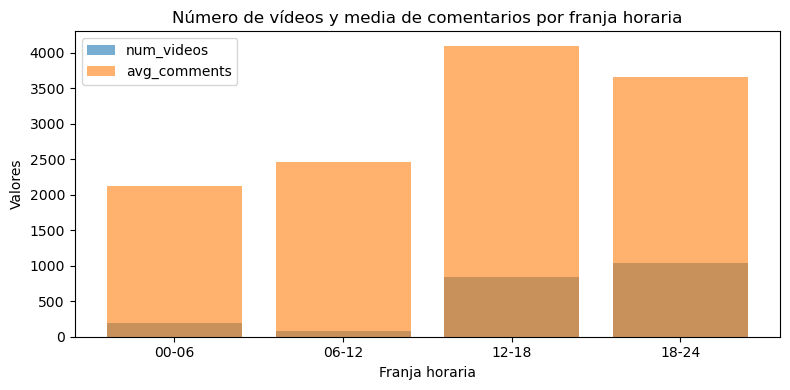

In [8]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(
    df_franjas["franja_horaria"],
    df_franjas["num_videos"],
    label="num_videos",
    alpha=0.6
)

ax.bar(
    df_franjas["franja_horaria"],
    df_franjas["avg_comments"],
    label="avg_comments",
    alpha=0.6
)

ax.set_title("Número de vídeos y media de comentarios por franja horaria")
ax.set_xlabel("Franja horaria")
ax.set_ylabel("Valores")
ax.legend()
plt.tight_layout()
plt.show()


**Tendencias del número de likes en los comentarios por canal** 

Filas devueltas: 5


,channel,r_pearson,n
0,QuantumFracture,0.026,10565
1,BBC Timestamp,0.018,2833
2,Mathologer,0.009,2234
3,3Blue1Brown,0.008,4470
4,Veritasium,0.002,9002


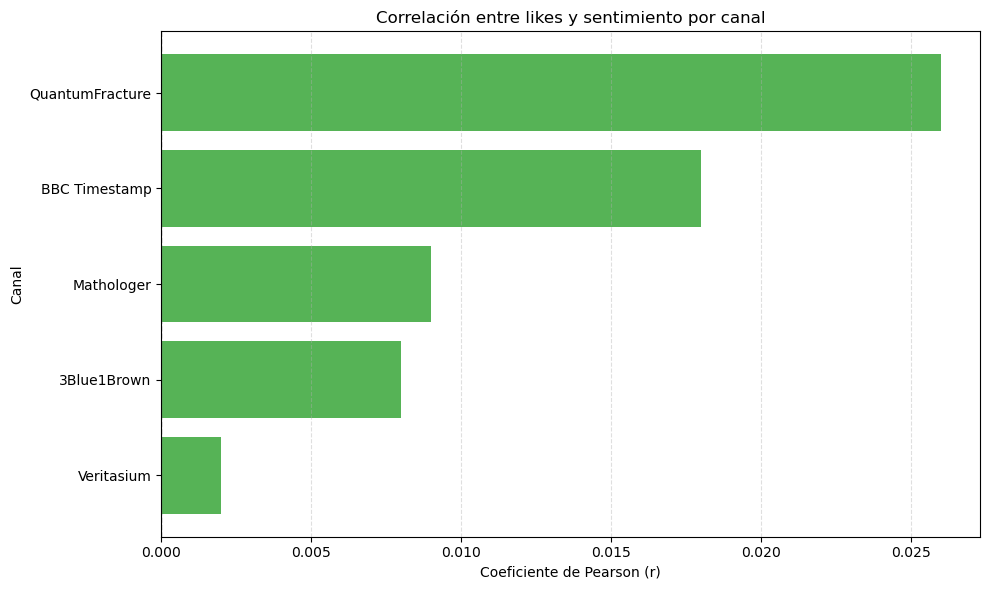

In [9]:
sql_sentiment_corr = """
SELECT
  ch.name AS channel,
  ROUND(corr(cm.like_count::float, cm.sentiment_score::float)::numeric, 3) AS r_pearson,
  COUNT(*) AS n
FROM public.comment cm
JOIN public.video v  ON v.id = cm.id_video
JOIN public.channel ch ON ch.id = v.id_channel
WHERE cm.like_count IS NOT NULL
  AND cm.sentiment_score IS NOT NULL
GROUP BY ch.name
HAVING COUNT(*) >= 30
ORDER BY r_pearson DESC;
"""

df_sentiment = run_query(sql_sentiment_corr)
print("Filas devueltas:", len(df_sentiment))
display(df_sentiment.head(15))

import matplotlib.pyplot as plt

df_plot = df_sentiment.sort_values("r_pearson", ascending=False).head(20)

plt.figure(figsize=(10, 6))
bars = plt.barh(df_plot["channel"], df_plot["r_pearson"],
                color=["#2ca02c" if r > 0 else "#d62728" for r in df_plot["r_pearson"]],
                alpha=0.8)

plt.title("Correlación entre likes y sentimiento por canal")
plt.xlabel("Coeficiente de Pearson (r)")
plt.ylabel("Canal")
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#### Búsqueda de videos similares

Primero lo hacemos solo por similitud entre contenidos y después por militud coseno usando embeddings para demostrar que el sistema permite llevar a cabo ambas búsquedas si el usuario lo desea.

In [10]:
from elasticsearch import Elasticsearch
import pandas as pd

es = Elasticsearch("http://elasticsearch:9200")
print(es.info().body["version"])

{'number': '8.7.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '09520b59b6bc1057340b55750186466ea715e30e', 'build_date': '2023-03-27T16:31:09.816451435Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}


**Búsqueda de videos por similitud de contenidos**

In [11]:

## Busqueda de aquellos videos mas similares a un nuevo video con un topic nuevo dandole el doble de peso a los titulos 

def similares_por_contenido(title: str, topic_or_desc: str, size: int = 10):
    q = {
        "size": size,
        "_source": ["id","title_raw","topic","language","duration_seconds",
                    "view_count","like_count","published_at","id_channel"],
        "query": {
            "multi_match": {
                "query": f"{title}\n{topic_or_desc or ''}",
                "fields": ["title_raw^2","topic"], 
                "type": "best_fields"
            }
        }
    }
    res = es.search(index="videos", body=q)
    rows = [{"score": h["_score"], **h["_source"]} for h in res["hits"]["hits"]]
    return pd.DataFrame(rows)

df = similares_por_contenido("Introducción a matrices", "álgebra lineal, operaciones básicas", size=15)
df.head()

,score,id,title_raw,duration_seconds,topic,published_at,view_count,like_count,language,id_channel
0,15.016190,3hCJILOpvWA,🚀Circuitos ELÉCTRICOS: Introducción al Régimen...,925,"This are the details of a youtube video, gener...",2025-08-24T20:21:59,17405,1171,es-419,UCa6V1UVOXN4wDm7RDQDoa6g
1,12.562542,e5NDNgCfVs8,📚 ¡MATEMÁTICA sin MEMORIZAR! - Clase #2: Opera...,5480,"This are the details of a youtube video, gener...",2024-03-10T08:55:35,207876,9131,es-419,UCa6V1UVOXN4wDm7RDQDoa6g
2,11.367714,kYB8IZa5AuE,Linear transformations and matrices | Chapter ...,659,"3blue1brown is a channel about animating math,...",2016-08-07T21:39:19,6271357,133201,en-US,UCYO_jab_esuFRV4b17AJtAw
3,10.921768,HtWh2S5L0A8,📖 Luego del Reto Viral 8:2*(2+2) ¿JERARQUÍA DE...,653,No summary avaliable,2019-08-11T01:30:08,152344,10136,es-419,UCa6V1UVOXN4wDm7RDQDoa6g
4,10.377901,v8VSDg_WQlA,Nonsquare matrices as transformations between ...,267,No summary avaliable,2016-08-16T21:59:23,1849382,33610,en-US,UCYO_jab_esuFRV4b17AJtAw


**Búsqueda de videos similares usando embeddings**

In [12]:
from sentence_transformers import SentenceTransformer

def similares_por_contenido(title: str, topic_or_desc: str = "", size: int = 10):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    query_text = f"{title} {topic_or_desc}" if topic_or_desc else title
    
    query_embedding = model.encode([query_text])[0].tolist()

    query = {
        "knn": {
            "field": "title_embedding",
            "query_vector": query_embedding,
            "k": size,
            "num_candidates": 100
        },
        "_source": ["id", "title_raw", "topic", "language", "duration_seconds",
                   "view_count", "like_count", "published_at", "id_channel"]
    }
    
    res = es.search(
        index="videos",
        body=query,
        size=size
    )
    
    rows = [{"score": h["_score"], **h["_source"]} for h in res["hits"]["hits"]]
    return pd.DataFrame(rows)

# Ejemplo de uso
df = similares_por_contenido("Introducción a matrices", "álgebra lineal, operaciones básicas", size=15)
df.head()

,score,id,title_raw,duration_seconds,topic,published_at,view_count,like_count,language,id_channel
0,0.786194,Ip3X9LOh2dk,"The determinant | Chapter 6, Essence of linear...",603,"3blue1brown is a channel about animating math,...",2016-08-10T22:31:18,4453029,97837,en-US,UCYO_jab_esuFRV4b17AJtAw
1,0.784768,XkY2DOUCWMU,Matrix multiplication as composition | Chapter...,604,No summary avaliable,2016-08-08T22:20:43,3892855,80327,en-US,UCYO_jab_esuFRV4b17AJtAw
2,0.764902,kYB8IZa5AuE,Linear transformations and matrices | Chapter ...,659,"3blue1brown is a channel about animating math,...",2016-08-07T21:39:19,6271357,133201,en-US,UCYO_jab_esuFRV4b17AJtAw
3,0.758695,TgKwz5Ikpc8,"Abstract vector spaces | Chapter 16, Essence o...",1006,"3blue1brown is a channel about animating math,...",2016-09-24T19:29:09,1621181,57233,en-US,UCYO_jab_esuFRV4b17AJtAw
4,0.748643,uQhTuRlWMxw,"Inverse matrices, column space and null space ...",729,"3blue1brown is a channel about animating math,...",2016-08-15T22:00:22,3425897,70835,en-US,UCYO_jab_esuFRV4b17AJtAw


**Consulta de youtube, buscar una serie de palabras (topic) y obtener los videos mas parecidos usando embeddings**

In [13]:
_model_st = SentenceTransformer('all-MiniLM-L6-v2')

def similares_por_topic(topic_text: str, size: int = 10,
                        channel_id: Optional[str] = None,
                        language: Optional[str] = None):
    """
    Devuelve los vídeos más similares a un 'topic' usando kNN sobre 'topic_embedding'.
    Opcionalmente filtra por canal (id_channel) y/o idioma (language).
    """
    query_vec = _model_st.encode([topic_text])[0].tolist()

    knn = {
        "field": "topic_embedding",
        "query_vector": query_vec,
        "k": size,
        "num_candidates": max(100, size * 5)
    }

    must_filters = []
    if channel_id:
        must_filters.append({"term": {"id_channel": channel_id}})
    if language:
        must_filters.append({"term": {"language": language}})
    if must_filters:
        knn["filter"] = {"bool": {"must": must_filters}}

    body = {
        "knn": knn,
        "_source": [
            "id","title_raw","topic","language","duration_seconds",
            "view_count","like_count","published_at","id_channel"
        ]
    }

    res = es.search(index="videos", body=body, size=size)
    hits = res.get("hits", {}).get("hits", [])

    if not hits:
        body_fallback = {
            "size": size,
            "_source": [
                "id","title_raw","topic","language","duration_seconds",
                "view_count","like_count","published_at","id_channel"
            ],
            "query": {
                "multi_match": {
                    "query": topic_text,
                    "fields": ["topic^2","description","title_raw"],
                    "type": "best_fields"
                }
            }
        }
        res = es.search(index="videos", body=body_fallback)
        hits = res.get("hits", {}).get("hits", [])

    rows = [{"id": h["_id"], "score": h["_score"], **h["_source"]} for h in hits]
    return pd.DataFrame(rows)

Se pueden buscar vídeos similares en general, vídeos similares de un canal en específico o vídeos similares en un idioma específico.

In [14]:
# similares por topic (sin filtros)
df = similares_por_topic("álgebra lineal, matrices, determinantes", size=15)
print("\n  Resultados generales (topic: Álgebra lineal, matrices, determinantes)")
print(df[["id", "score", "title_raw"]]
      .to_string(index=False, justify="left", col_space=15, max_colwidth=None))

# filtrando al mismo canal
df_can = similares_por_topic("circuitos eléctricos en transitorio", size=12, channel_id="UCa6V1UVOXN4wDm7RDQDoa6g")
print("\n Resultados filtrados por un canal (topic: circuitos eléctricos)")
print(df_can[["id", "score", "title_raw"]]
      .to_string(index=False, justify="left", col_space=15, max_colwidth=None))

# filtrando por idioma
df_es = similares_por_topic("derivadas y reglas de cálculo", size=10, language="es-419")
print("\n  Resultados en español (topic: Derivadas y reglas de cálculo)")
print(df_es[["id", "score", "title_raw"]]
      .to_string(index=False, justify="left", col_space=15, max_colwidth=None))


  Resultados generales (topic: Álgebra lineal, matrices, determinantes)
id               score          title_raw                                                                                      
Ip3X9LOh2dk     0.853140                                                 The determinant | Chapter 6, Essence of linear algebra
eu6i7WJeinw     0.751812                                                 Cross products | Chapter 10, Essence of linear algebra
kYB8IZa5AuE     0.745048                             Linear transformations and matrices | Chapter 3, Essence of linear algebra
rHLEWRxRGiM     0.744154                        Three-dimensional linear transformations | Chapter 5, Essence of linear algebra
fNk_zzaMoSs     0.734761                                                         Vectors | Chapter 1, Essence of linear algebra
BaM7OCEm3G0     0.734316          Cross products in the light of linear transformations | Chapter 11, Essence of linear algebra
kjBOesZCoqc     0.732546       

#### Búsqueda de comentarios similares 

El sistema permite tanto buscar comentarios similares en un video que se hayan detectado que son similares como con comentarios en general

**Búsqueda de comentarios similares en videos similares usando similitud de contenido**

In [15]:
def similares_en_canal(video_id, size=10):
    doc = es.get(index="videos", id=video_id)["_source"]
    q = {
        "size": size,
        "_source": ["id","id_channel","title_raw","topic","language","duration_seconds","view_count","like_count","published_at"],
        "query": {
            "bool": {
                "filter": [{"term": {"id_channel": doc["id_channel"]}}],
                "should": [
                    {"match": {"topic": doc.get("topic","")}},
                    {"match": {"title_raw": {"query": doc.get("title_raw",""), "boost": 2}}}
                ],
                "minimum_should_match": 1
            }
        }
    }
    res = es.search(index="videos", body=q)
    vids = [h["_id"] for h in res["hits"]["hits"] if h["_id"] != video_id]
    df = pd.DataFrame([{**h["_source"], "id_video": h["_id"], "_score": h["_score"]} for h in res["hits"]["hits"]])
    return vids, df

def _comentarios_de_video(video_id, max_docs=50):
    q = {
        "size": max_docs,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"],
        "query": {"term": {"id_video": video_id}}
    }
    res = es.search(index="comments", body=q)
    return [h["_source"]["text"] for h in res["hits"]["hits"] if h["_source"].get("text")]

def comentarios_similares_entre_videos_similares(video_id, size=50, semillas_max=80, candidatos_por_video=200):
    similar_ids, df_videos = similares_en_canal(video_id, size=10)
    if not similar_ids:
        return pd.DataFrame(), df_videos

    semillas = _comentarios_de_video(video_id, max_docs=semillas_max)
    if not semillas: 
        vsrc = es.get(index="videos", id=video_id)["_source"]
        semillas = [f"{vsrc.get('title_raw','')} {vsrc.get('topic','')}"]

    q = {
        "size": size,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"],
        "query": {
            "bool": {
                "filter": [{"terms": {"id_video": similar_ids}}],
                "must": {
                    "more_like_this": {
                        "fields": ["text"],
                        "like": [{"doc": {"text": t}} for t in semillas],
                        "min_term_freq": 1,
                        "min_doc_freq": 1,
                        "max_query_terms": 50
                    }
                }
            }
        }
    }
    res = es.search(index="comments", body=q)
    rows = []
    for h in res["hits"]["hits"]:
        src = h["_source"]
        rows.append({
            "score": h["_score"],
            "comment_id": src.get("id"),
            "id_video": src.get("id_video"),
            "text": src.get("text"),
            "published_at": src.get("published_at"),
            "like_count": src.get("like_count"),
            "sentiment_score": src.get("sentiment_score"),
        })
    df_comentarios = pd.DataFrame(rows)

    return df_comentarios, df_videos

def comentarios_similares_a_un_comentario(comment_id, size=50):
    c = es.get(index="comments", id=comment_id)["_source"]
    video_id = c["id_video"]

    similar_ids, df_videos = similares_en_canal(video_id, size=10)
    if not similar_ids:
        return pd.DataFrame(), df_videos

    q = {
        "size": size,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"],
        "query": {
            "bool": {
                "filter": [{"terms": {"id_video": similar_ids}}],
                "must": {
                    "more_like_this": {
                        "fields": ["text"],
                        "like": [{"_index": "comments", "_id": comment_id}],
                        "min_term_freq": 1,
                        "min_doc_freq": 1,
                        "max_query_terms": 50
                    }
                },
                "must_not": [{"term": {"_id": comment_id}}]
            }
        }
    }
    res = es.search(index="comments", body=q)
    rows = [{
        "score": h["_score"],
        "comment_id": h["_source"]["id"],
        "id_video": h["_source"]["id_video"],
        "text": h["_source"]["text"],
        "published_at": h["_source"].get("published_at"),
        "like_count": h["_source"].get("like_count"),
        "sentiment_score": h["_source"].get("sentiment_score"),
    } for h in res["hits"]["hits"]]
    return pd.DataFrame(rows), df_videos


In [16]:
df_comments, df_videos = comentarios_similares_a_un_comentario("UgyBUfIkQCf8wvDoTux4AaABAg")


In [17]:
print("COMENTARIOS SIMILARES:")
display(df_comments.head(10))

print("VIDEOS SIMILARES:")
display(df_videos.head(10))

COMENTARIOS SIMILARES:


,score,comment_id,id_video,text,published_at,like_count,sentiment_score
0,26.283504,UgwXmSb5609bidhNMJ54AaABAg,YxK7UTlm1Ao,La tierra es plana!,2024-02-25,0,1
1,15.785059,UgwuOX0_NjWCwkkHNMJ4AaABAg,k-NzJxrBdEc,jejejejejeje llevamos comiendo helado de vaini...,2025-07-28,0,2
2,15.182452,Ugx2gQWUWc7HCnhZQjR4AaABAg,5WZb_xCX2KQ,Es importante informarse bien sobre el tema co...,2024-10-30,0,3
3,14.862182,UgzzQ5agp4IY-HmWRIZ4AaABAg,5WZb_xCX2KQ,El horóscopo que crees que eres no es ya que e...,2024-11-23,1,2
4,14.689989,UgyzEr-mmicypgQRXD14AaABAg,G6A_Zh7lpoM,2:15 Pues si ya no se pueden usar telescopios ...,2025-04-28,0,3
5,12.659416,UgwFPaprmVDpZw3Lhbd4AaABAg,iExj0mk1Wno,"No es solo azul. Por la noche es negro, si tie...",2025-04-16,0,2
6,12.488958,UgwFdFVWMKcYa7FwODZ4AaABAg,pqEidVW9da0,Y la semana que viene resolveremos de una vez ...,2021-05-23,4268,3
7,11.540150,UgxDzhVy9wj5Vv5ir8J4AaABAg,5WZb_xCX2KQ,"La astrologia tiene sus defectos sin duda, por...",2025-07-13,0,1
8,11.407455,UgzhT6wGP4DyGgWDKfJ4AaABAg,5WZb_xCX2KQ,La astrología es mucho más compleja que este v...,2024-09-09,0,2
9,11.052731,UgzpKy9A_Vixql14M0t4AaABAg,YxK7UTlm1Ao,Creo que el ejemplo de la sábana de tela y la...,2024-07-14,0,3


VIDEOS SIMILARES:


,id,title_raw,duration_seconds,topic,published_at,view_count,like_count,language,id_channel,id_video,_score
0,hp6eywJJJmU,¿Por qué Europa Lanza sus Cohetes desde Aquí?,60,This are the title and description of a youtub...,2025-11-05T14:24:10,173929,8703,es,UCbdSYaPD-lr1kW27UJuk8Pw,hp6eywJJJmU,181.314510
1,5WZb_xCX2KQ,"Por qué la Astrología ""Funciona""",1010,This are the title and description of a youtub...,2020-12-31T17:00:11,889766,95126,es,UCbdSYaPD-lr1kW27UJuk8Pw,5WZb_xCX2KQ,60.368988
2,G6A_Zh7lpoM,Por qué los Astrónomos ODIAN a Elon Musk (y po...,749,This are the title and description of a youtub...,2020-10-08T18:00:04,3031874,200758,es,UCbdSYaPD-lr1kW27UJuk8Pw,G6A_Zh7lpoM,58.330055
3,pqEidVW9da0,Por qué el Dinero No Vale NADA (y por qué las ...,1550,This are the title and description of a youtub...,2021-05-23T18:01:33,2825192,152424,es,UCbdSYaPD-lr1kW27UJuk8Pw,pqEidVW9da0,57.788700
4,iExj0mk1Wno,¿Por qué el Mar es Azul?,52,This are the title and description of a youtub...,2024-11-28T15:29:07,4932642,456196,es,UCbdSYaPD-lr1kW27UJuk8Pw,iExj0mk1Wno,57.677834
5,0fhpCgFbcHU,No Entiendo Por Qué el Cielo es Azul,700,This are the title and description of a youtub...,2024-10-27T19:00:00,363278,23598,es,UCbdSYaPD-lr1kW27UJuk8Pw,0fhpCgFbcHU,57.588993
6,k-NzJxrBdEc,Por qué Nuestro Sistema Solar es RARO | Exopla...,620,This are the title and description of a youtub...,2020-07-16T18:00:07,2421903,97373,es,UCbdSYaPD-lr1kW27UJuk8Pw,k-NzJxrBdEc,56.301613
7,SS6-DwIPXUc,Por qué los Dioses Odian a Einstein,635,This are the title and description of a youtub...,2019-03-09T17:27:08,2071930,109463,es,UCbdSYaPD-lr1kW27UJuk8Pw,SS6-DwIPXUc,55.938488
8,Tg7sfaklSEo,¿Por qué Existe el Humor?,1740,This are the title and description of a youtub...,2024-09-19T21:42:14,207848,15709,es,UCbdSYaPD-lr1kW27UJuk8Pw,Tg7sfaklSEo,55.403763
9,YxK7UTlm1Ao,¿Por qué la Energía Gravitatoria es Negativa?,486,This are the title and description of a youtub...,2018-04-19T17:02:39,936862,49054,es,UCbdSYaPD-lr1kW27UJuk8Pw,YxK7UTlm1Ao,55.242958


**Búsqueda de comentarios similares usando embeddings**

In [18]:
from typing import Optional, List
import pandas as pd

def _get_comment_source(comment_id: str) -> dict:
    """Carga el documento de comments desde ES."""
    return es.get(index="comments", id=comment_id)["_source"]

def _get_video_source(video_id: str) -> dict:
    """Carga el vídeo desde ES (para sacar canal)."""
    return es.get(index="videos", id=video_id)["_source"]

def _video_ids_de_canal(channel_id: str, limit: int = 10000) -> List[str]:
    """Devuelve todos los video_id de un canal para poder filtrar comments por esos vídeos."""
    body = {
        "size": limit,
        "_source": False,
        "query": {"term": {"id_channel": channel_id}}
    }
    res = es.search(index="videos", body=body)
    return [h["_id"] for h in res["hits"]["hits"]]

def comentarios_similares_por_embedding(comment_id: str, size: int = 50) -> pd.DataFrame:
    """
    Busca comentarios más parecidos (kNN) al comentario dado usando comment_embedding.
    Búsqueda global (todo el índice). Excluye el propio comentario.
    """
    src = _get_comment_source(comment_id)
    qvec = src.get("comment_embedding")
    if not qvec:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer("all-MiniLM-L6-v2")
        qvec = model.encode([src.get("text","")])[0].tolist()

    knn = {
        "field": "comment_embedding",
        "query_vector": qvec,
        "k": size,
        "num_candidates": max(100, size * 10)
    }

    body = {
        "knn": knn,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"]
    }

    res = es.search(index="comments", body=body, size=size)
    rows = []
    for h in res.get("hits", {}).get("hits", []):
        s = h["_source"]
        if s.get("id") == comment_id:
            continue 
        rows.append({
            "score": h["_score"],
            "comment_id": s.get("id"),
            "id_video": s.get("id_video"),
            "text": s.get("text"),
            "published_at": s.get("published_at"),
            "like_count": s.get("like_count"),
            "sentiment_score": s.get("sentiment_score"),
        })
    return pd.DataFrame(rows)

def comentarios_similares_mismo_canal_por_embedding(comment_id: str, size: int = 50) -> pd.DataFrame:
    """
    Igual que la anterior pero filtrando a comentarios de vídeos del mismo canal
    que el comentario semilla.
    """
    csrc = _get_comment_source(comment_id)
    qvec = csrc.get("comment_embedding")
    if not qvec:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer("all-MiniLM-L6-v2")
        qvec = model.encode([csrc.get("text","")])[0].tolist()

    # 2) canal del vídeo origen
    vid_src = _get_video_source(csrc["id_video"])
    channel_id = vid_src["id_channel"]
    video_ids = _video_ids_de_canal(channel_id)

    knn = {
        "field": "comment_embedding",
        "query_vector": qvec,
        "k": size,
        "num_candidates": max(100, size * 10),
        "filter": {  
            "terms": {"id_video": video_ids}
        }
    }

    body = {
        "knn": knn,
        "_source": ["id","id_video","text","published_at","like_count","sentiment_score"]
    }

    res = es.search(index="comments", body=body, size=size)
    rows = []
    for h in res.get("hits", {}).get("hits", []):
        s = h["_source"]
        if s.get("id") == comment_id:
            continue
        rows.append({
            "score": h["_score"],
            "comment_id": s.get("id"),
            "id_video": s.get("id_video"),
            "text": s.get("text"),
            "published_at": s.get("published_at"),
            "like_count": s.get("like_count"),
            "sentiment_score": s.get("sentiment_score"),
        })
    return pd.DataFrame(rows)


In [19]:
# similares globales (en todo el índice)
df_sim = comentarios_similares_por_embedding("UgyBUfIkQCf8wvDoTux4AaABAg", size=10)

# similares pero dentro del mismo canal
df_sim_canal = comentarios_similares_mismo_canal_por_embedding("UgyBUfIkQCf8wvDoTux4AaABAg", size=10)

# salida bonita solo con id, score y texto
print(df_sim[["comment_id","score","text"]].to_string(index=False, max_colwidth=None))


                comment_id    score                                                                                                       text
UgyM6ZimPPreYIRPDrV4AaABAg 0.894835                                                                                         LA TIERRA ES PLANA
Ugziq_O7XaZYZNJjtpt4AaABAg 0.894835                                                                                         La tierra es plana
Ugw9PuxnwXlYymG3HHd4AaABAg 0.882060                                                                                         La.tierra.es.plana
UgwXmSb5609bidhNMJ54AaABAg 0.873436                                                                                        La tierra es plana!
UgwLBcnthGCLpC4DxHl4AaABAg 0.858522                                                                                 LA TIERRA ES PLANA MASONES
UgxMQeIka8e1MI17KY94AaABAg 0.852247                                                                             La tierra no es plana es negrs

#### Búsqueda de comentarios positivos dado un tema

In [20]:
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import logging
from functools import lru_cache

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

@lru_cache(maxsize=100)
def generar_embedding(texto: str) -> list:
    """Genera embedding con caché para textos repetidos"""
    return model.encode(texto).tolist()

CONSULTA_BASE = {
    "query": {
        "script_score": {
            "query": {
                "bool": {
                    "must": [{"range": {"sentiment_score": {"gte": 1}}}],
                    "filter": [{"range": {"like_count": {"gte": 5}}}]
                }
            },
            "script": {
                "source": """
                    if (doc['comment_embedding'].size() == 0) return 0;
                    double similitud = cosineSimilarity(params.query_vector, 'comment_embedding');
                    return similitud + 1.0;  // Ajuste para evitar negativos
                """,
                "params": {"query_vector": None}
            }
        }
    },
    "size": 20,
    "_source": ["text", "sentiment_score", "like_count", "published_at", "id_video"],
    "sort": [{"_score": {"order": "desc"}}]
}

def buscar_comentarios_por_tema(tema: str, min_likes: int = 5, min_sentiment: int = 1, size: int = 20) -> dict:
    """
    Búsqueda semántica de comentarios para UN tema específico
    """
    embedding_tema = generar_embedding(tema)
    
    consulta = CONSULTA_BASE.copy()
    consulta["size"] = size
    consulta["query"]["script_score"]["script"]["params"]["query_vector"] = embedding_tema
    consulta["query"]["script_score"]["query"]["bool"]["must"][0]["range"]["sentiment_score"]["gte"] = min_sentiment
    consulta["query"]["script_score"]["query"]["bool"]["filter"][0]["range"]["like_count"]["gte"] = min_likes
    
    try:
        logger.info(f"Buscando comentarios sobre: '{tema}'")
        respuesta = es.search(index="comments", body=consulta)
        logger.info(f"Encontrados {respuesta['hits']['total']['value']} comentarios")
        return respuesta
    except Exception as e:
        logger.error(f"Error en búsqueda: {str(e)}")
        raise

def mostrar_resultados(respuesta: dict, tema: str, max_caracteres: int = 100):
    """
    Muestra los resultados de forma formateada y optimizada
    """
    total = respuesta['hits']['total']['value']
    hits = respuesta['hits']['hits']
    
    print(f"TEMA DE BÚSQUEDA: {tema}")
    print(f"Comentarios encontrados: {total}")
    print("=" * 60)
    
    if total == 0:
        print("No se encontraron comentarios para este tema")
        return
    
    for i, hit in enumerate(hits):
        fuente = hit['_source']
        similitud = hit['_score'] - 1.0 
        
        print(f"#{i+1} (Similitud: {similitud:.3f})")
        print(f"{fuente['text'][:max_caracteres]}{'...' if len(fuente['text']) > max_caracteres else ''}")
        print(f"Sentimiento: {fuente['sentiment_score']} | Likes: {fuente.get('like_count', 0)}")
        print(f"Fecha: {fuente.get('published_at', 'N/A')}")
        print("-" * 50)

tema = "tengo una pregunta"


try:
    resultado = buscar_comentarios_por_tema(
        tema=tema,
        min_likes=5,
        min_sentiment=3,
        size=10
    )

    mostrar_resultados(resultado, tema)

except Exception as e:
    logger.error(f"Error en la ejecución: {e}")

2025-11-12 19:58:41,648 - INFO - Use pytorch device_name: cpu
2025-11-12 19:58:41,650 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 19:58:43,156 - INFO - Buscando comentarios sobre: 'tengo una pregunta'
2025-11-12 19:58:43,203 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.012s]
2025-11-12 19:58:43,204 - INFO - Encontrados 655 comentarios


TEMA DE BÚSQUEDA: tengo una pregunta
Comentarios encontrados: 655
#1 (Similitud: 0.603)
Como nuevo inversor, debes tener en cuenta cuatro cosas:

1. Tener una mentalidad a largo plazo.
2. ...
Sentimiento: 3 | Likes: 87
Fecha: 2025-05-22
--------------------------------------------------
#2 (Similitud: 0.580)
¡No os cortéis y aprovechad para preguntar todas vuestras dudas aquí en las comentarios! Seguro que ...
Sentimiento: 4 | Likes: 2317
Fecha: 2017-06-02
--------------------------------------------------
#3 (Similitud: 0.571)
una pequeña corrección, si tiene caras, no es un polígono, es un poliedro.
Sentimiento: 3 | Likes: 12
Fecha: 2024-09-30
--------------------------------------------------
#4 (Similitud: 0.562)
mi compa cuando llegan las minitas chidas
Sentimiento: 3 | Likes: 5
Fecha: 2024-08-27
--------------------------------------------------
#5 (Similitud: 0.552)
No entiendo nada de lo que dicen, pero bueno. Saludos ✌️
Sentimiento: 4 | Likes: 21
Fecha: 2023-02-03
------------

#### Búsqueda de comentarios duplicados en distintos videos

Iniciando detección de comentarios duplicados en todas las fechas...


2025-11-12 19:58:43,744 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.496s]


Analizando 10000 comentarios de todas las fechas...
Buscando comentarios duplicados...
Se encontraron 356 comentarios duplicados
Agrupados en 90 textos diferentes

GENERANDO GRÁFICO DE FRECUENCIAS


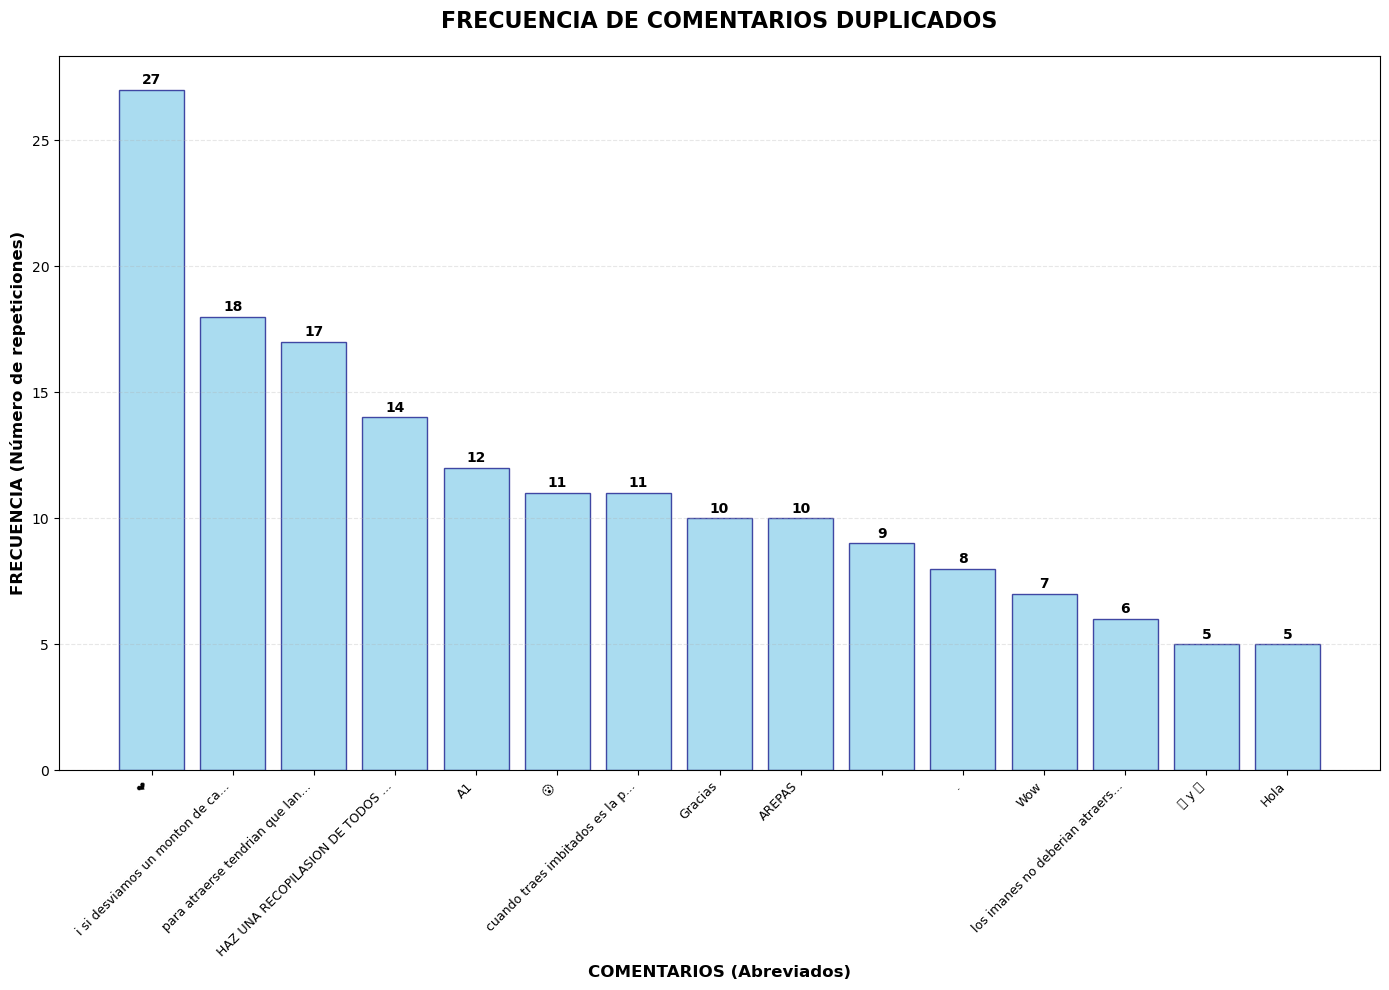


TEXTO COMPLETO DE LOS COMENTARIOS DEL GRÁFICO

1. [27 repeticiones] - ❤️
   Texto completo: "❤️"

2. [18 repeticiones] - i si desviamos un monton de ca...
   Texto completo: "i si desviamos un monton de calor de la sperfisie a el nucleo de la tierra"

3. [17 repeticiones] - para atraerse tendrian que lan...
   Texto completo: "para atraerse tendrian que lansarse particulas de masa negatiba"

4. [14 repeticiones] - HAZ UNA RECOPILASION DE TODOS ...
   Texto completo: "HAZ UNA RECOPILASION DE TODOS TUS VIDEOS DE ASTROLOGIA EN UN VIDEO"

5. [12 repeticiones] - A1
   Texto completo: "A1"

6. [11 repeticiones] - 😮
   Texto completo: "😮"

7. [11 repeticiones] - cuando traes imbitados es la p...
   Texto completo: "cuando traes imbitados es la parte mas aburrida"

8. [10 repeticiones] - Gracias
   Texto completo: "Gracias"

9. [10 repeticiones] - AREPAS
   Texto completo: "AREPAS"

10. [9 repeticiones] - 
   Texto completo: ""

11. [8 repeticiones] - .
   Texto completo: "."

12. [7 repetici

In [21]:
# DETECCIÓN DE COMENTARIOS DUPLICADOS - TODAS LAS FECHAS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def detectar_comentarios_duplicados():
    """
    Detección de comentarios duplicados en todas las fechas
    """
    
    # Consulta para obtener todos los comentarios
    query = {
        "size": 10000,
        "query": {
            "match_all": {}
        },
        "_source": ["id", "text", "published_at", "id_video", "like_count"]
    }
    
    try:
        # Obtener comentarios
        res = es.search(index="comments", body=query)
        comentarios = [{"id": hit["_id"], **hit["_source"]} for hit in res["hits"]["hits"]]
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()
    
    if not comentarios:
        print("No se encontraron comentarios")
        return pd.DataFrame()
    
    df = pd.DataFrame(comentarios)
    print(f"Analizando {len(df)} comentarios de todas las fechas...")
    
    # Buscar textos duplicados
    print("Buscando comentarios duplicados...")
    
    # Identificar duplicados exactos
    duplicados = df[df.duplicated('text', keep=False)]
    
    if duplicados.empty:
        print("No se encontraron comentarios duplicados")
        return pd.DataFrame()
    
    # Agrupar por texto duplicado
    grupos_duplicados = duplicados.groupby('text').agg({
        'id': 'count',
        'published_at': ['min', 'max'],
        'id_video': lambda x: list(x.unique()),
        'like_count': 'mean'
    }).reset_index()
    
    # Renombrar columnas
    grupos_duplicados.columns = ['text', 'cantidad', 'fecha_min', 'fecha_max', 'videos', 'likes_promedio']
    
    # Ordenar por cantidad (mayor a menor)
    grupos_duplicados = grupos_duplicados.sort_values('cantidad', ascending=False)
    
    print(f"Se encontraron {len(duplicados)} comentarios duplicados")
    print(f"Agrupados en {len(grupos_duplicados)} textos diferentes")
    
    return grupos_duplicados, duplicados

def crear_grafico_comentarios_duplicados(grupos_duplicados):
    """Crear gráfico de barras de comentarios duplicados"""
    
    if grupos_duplicados.empty:
        print("No hay comentarios duplicados para graficar")
        return
    
    # Limitar a los top 15 para mejor visualización
    top_duplicados = grupos_duplicados.head(15)
    
    # Crear abreviaturas para el eje X
    textos = top_duplicados['text'].tolist()
    frecuencias = top_duplicados['cantidad'].tolist()
    
    # Generar abreviaturas inteligentes
    abreviaturas = []
    textos_completos = []
    
    for texto in textos:
        # Abreviatura: primeros 30 caracteres + "..."
        if len(texto) > 30:
            abrev = texto[:30] + "..."
        else:
            abrev = texto
        
        abreviaturas.append(abrev)
        textos_completos.append(texto)
    
    # Crear el gráfico
    plt.figure(figsize=(14, 10))
    
    # Gráfico de barras
    bars = plt.bar(range(len(abreviaturas)), frecuencias, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Personalizar el gráfico
    plt.title('FRECUENCIA DE COMENTARIOS DUPLICADOS', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('COMENTARIOS (Abreviados)', fontsize=12, fontweight='bold')
    plt.ylabel('FRECUENCIA (Número de repeticiones)', fontsize=12, fontweight='bold')
    
    # Configurar eje X con las abreviaturas
    plt.xticks(range(len(abreviaturas)), abreviaturas, rotation=45, ha='right', fontsize=9)
    
    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # Añadir grid para mejor lectura
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Ajustar layout para que quepan las etiquetas
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()
    
    # Mostrar leyenda con textos completos
    print("\n" + "="*80)
    print("TEXTO COMPLETO DE LOS COMENTARIOS DEL GRÁFICO")
    print("="*80)
    
    for i, (abrev, texto_completo, freq) in enumerate(zip(abreviaturas, textos_completos, frecuencias), 1):
        print(f"\n{i}. [{freq} repeticiones] - {abrev}")
        print(f"   Texto completo: \"{texto_completo}\"")
    
    return top_duplicados

def mostrar_comentarios_duplicados(grupos_duplicados, duplicados):
    """Mostrar todos los comentarios duplicados completos"""
    
    if grupos_duplicados.empty:
        print("No hay comentarios duplicados")
        return
    
    print("\n" + "="*80)
    print("COMENTARIOS DUPLICADOS DETECTADOS - TEXTO COMPLETO")
    print("="*80)
    
    # Mostrar cada grupo de duplicados
    for idx, grupo in grupos_duplicados.iterrows():
        print(f"\n{'='*60}")
        print(f" GRUPO {idx + 1} - {grupo['cantidad']} COMENTARIOS IDÉNTICOS")
        print(f"{'='*60}")
        
        print(f" TEXTO COMPLETO:")
        print(f"   \"{grupo['text']}\"")
        
        print(f"\n ESTADÍSTICAS:")
        print(f"   • Cantidad: {grupo['cantidad']} comentarios idénticos")
        print(f"   • Videos diferentes: {len(grupo['videos'])}")
        print(f"   • Videos: {', '.join(grupo['videos'])}")
        print(f"   • Rango de fechas: {grupo['fecha_min']} a {grupo['fecha_max']}")
        print(f"   • Likes promedio: {grupo['likes_promedio']:.1f}")
        
        # Mostrar algunos ejemplos individuales
        print(f"\n EJEMPLOS DE COMENTARIOS DUPLICADOS:")
        comentarios_grupo = duplicados[duplicados['text'] == grupo['text']].head(5)
        
        for i, (_, comentario) in enumerate(comentarios_grupo.iterrows(), 1):
            print(f"      Video: {comentario['id_video']}")
            print(f"      Fecha: {comentario['published_at']}")
            print(f"      Likes: {comentario.get('like_count', 'N/A')}")
            print()

# EJECUTAR DETECCIÓN
print("Iniciando detección de comentarios duplicados en todas las fechas...")
grupos_duplicados, todos_duplicados = detectar_comentarios_duplicados()

# Mostrar resultados completos
#mostrar_comentarios_duplicados(grupos_duplicados, todos_duplicados)

# Crear y mostrar el gráfico
if not grupos_duplicados.empty:
    print("\n" + "="*80)
    print("GENERANDO GRÁFICO DE FRECUENCIAS")
    print("="*80)
    
    top_duplicados = crear_grafico_comentarios_duplicados(grupos_duplicados)
    
    # Estadísticas generales
    print(f"\n ESTADÍSTICAS GENERALES:")
    print(f"   • Total de comentarios duplicados: {len(todos_duplicados)}")
    print(f"   • Textos diferentes duplicados: {len(grupos_duplicados)}")
    print(f"   • Frecuencia máxima: {grupos_duplicados['cantidad'].max()}")
    print(f"   • Frecuencia promedio: {grupos_duplicados['cantidad'].mean():.1f}")
else:
    print("No hay datos para generar el gráfico")

In [22]:
!pip install SPARQLWrapper

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Detección de Comunidades por Comentarios de Videos Similares

In [23]:
global available_video_ids
with open('unique_video_ids.json', 'r') as f:
    available_video_ids = json.load(f)

In [36]:
def get_videos(es: Elasticsearch, size: int):
    """
    Busca videos en Elasticsearch y devuelve un DataFrame con ID y título.
    """
    
    ids = available_video_ids[:size]
    search_body = {
        "query": {
            # Usamos 'terms' en lugar de 'match_all'
            "terms": {
                # El campo a buscar es 'id' (el campo de tu documento)
                "id": ids 
            }
        },
        "size": size, # El tamaño se mantiene para limitar los resultados
        # Limitar los campos devueltos
        "_source": ["id", "title_raw"] 
        }

    try:
        response = es.search(index="videos", body=search_body)
        hits = response.get('hits', {}).get('hits', [])
        rows = []
        for hit in hits:
            row = {
                "id_video": hit['_source']['id'],
                "title_raw": hit['_source']['title_raw']
            }
            rows.append(row)

        return pd.DataFrame(rows)

    except Exception as e:
        print(f" Ocurrió un error al buscar videos: {e}")
        return pd.DataFrame()

In [37]:
def video_mas_similar(title: str):
    # Cargar el modelo de sentence-transformers
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embedding = model.encode([title])[0].tolist()
    query = {
        "knn": { 
            "field": "title_embedding",
            "query_vector": query_embedding,
            "k": 2,
            "num_candidates": 100,
            "filter": {
                "terms": {
                    "id": available_video_ids
                }
            }
        },
        "_source": ["id", "title_raw"]
    }
    
    res = es.search(
        index="videos",
        body=query,
    )
    
    rows = [{"score": h["_score"], **h["_source"]} for h in res["hits"]["hits"] if h["_score"] != 1.0]
    return pd.DataFrame(rows)

In [38]:
def obtener_comentarios_por_video(es_client, video_id):
    """
    Busca y retorna todos los comentarios para un ID de video específico.
    """
    search_body = {
        "query": {
            "term": {
                "id_video": video_id
            }
        },
        "size": 10000
    }

    try:
        response = es_client.search(index="comments", body=search_body)
        total_hits = response['hits']['total']['value']
        hits = response['hits']['hits']
        print(f"--- Encontrados {total_hits} comentarios para el video ID: {video_id} ---")
        
        comentarios = [hit['_source']['comment_embedding'] for hit in hits]
        return {video_id: comentarios}

    except Exception as e:
        print(f" Ocurrió un error al buscar comentarios: {e}")
        return []


In [40]:
def embedding_dimensionality_reduction(embeddings):
    embs = np.array(embeddings)
    print(embs.shape)
    embs_2dims = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(embs)
    print(embs_2dims.shape)
    return embs_2dims

In [41]:
def create_dataframe(video_comentarios_emb, video_comentarios_emb2dims):
    data = []
    key = list(video_comentarios_emb.keys())[0]
    for emb in video_comentarios_emb2dims:
        data.append({'id_video': key, 'comment_emb2dims': emb})
    return pd.DataFrame(data)

In [39]:
def graficar_embeddings_por_id(df: pd.DataFrame, embedding_col: str, id_col: str):
    
    df['X'] = df[embedding_col].apply(lambda x: x[0])
    df['Y'] = df[embedding_col].apply(lambda x: x[1])

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='X', 
        y='Y', 
        hue=id_col, 
        data=df, 
        s=100,
        alpha=0.7
    )
    
    plt.title(f'Visualización de Embeddings 2D coloreados por {id_col}', fontsize=16)
    plt.xlabel('Componente X del Embedding', fontsize=12)
    plt.ylabel('Componente Y del Embedding', fontsize=12)
    plt.legend(title=id_col)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [42]:
def compare_video_comments(es, video_iloc):
    # Get videos to compare
    video1 = get_videos(es, size=1500).iloc[video_iloc]
    print(video1)
    video2 = video_mas_similar(video1['id_video']).iloc[0][['id','title_raw']]
    print(video2)
    
    # Get embeddings
    video1_comments_embs = obtener_comentarios_por_video(es, video1['id_video'])
    video2_comments_embs = obtener_comentarios_por_video(es, video2['id'])
    
    # ABORT IF WE HAVE LESS THAN 10 COMMENTS:
    n_comments1 = len(list(video1_comments_embs.values())[0])
    n_comments2 = len(list(video2_comments_embs.values())[0])
    if n_comments1 < 10 or n_comments2 < 10:
        pass
    else:
        # Get 2 dimension embeddings
        video_comments_embd2dims = embedding_dimensionality_reduction(list(video1_comments_embs.values())[0] + list(video2_comments_embs.values())[0])
        video1_comments_emb2dims = video_comments_embd2dims[:n_comments1]
        video2_comments_emb2dims = video_comments_embd2dims[n_comments2:]

        # Transform it into a DataFrame
        df1_video_comments_emb2dims = create_dataframe(video1_comments_embs, video1_comments_emb2dims)
        df2_video_comments_emb2dims = create_dataframe(video2_comments_embs, video2_comments_emb2dims)

        df_video_comments_emb2dims = pd.concat([df1_video_comments_emb2dims, df2_video_comments_emb2dims])
        print(df_video_comments_emb2dims.head())

        return df_video_comments_emb2dims

2025-11-12 20:02:26,125 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.239s]
2025-11-12 20:02:26,131 - INFO - Use pytorch device_name: cpu
2025-11-12 20:02:26,132 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


id_video                   jn5M48MVWyg
title_raw    Is Dust Mostly Dead Skin?
Name: 2, dtype: object


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:02:27,749 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.008s]
2025-11-12 20:02:27,786 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]
2025-11-12 20:02:27,816 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]


id                                                 W1gW1dHRsOw
title_raw    For anyone who might not know how links in sho...
Name: 0, dtype: object
--- Encontrados 20 comentarios para el video ID: jn5M48MVWyg ---
--- Encontrados 20 comentarios para el video ID: W1gW1dHRsOw ---
(40, 384)
(40, 2)
      id_video          comment_emb2dims
0  jn5M48MVWyg   [-51.988815, -95.41762]
1  jn5M48MVWyg   [17.695524, -122.82087]
2  jn5M48MVWyg    [161.00209, -72.45959]
3  jn5M48MVWyg  [-2.2370536, -102.31097]
4  jn5M48MVWyg    [138.83942, -64.14909]
Preparando datos para graficar...


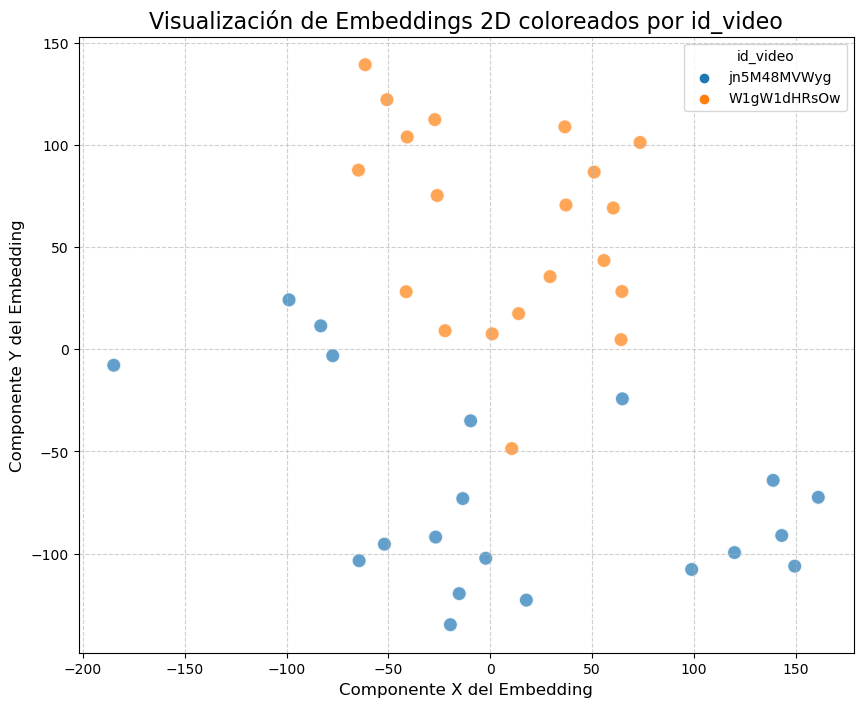

In [43]:
df_video_comments_emb2dims = compare_video_comments(es, video_iloc=2)
graficar_embeddings_por_id(df_video_comments_emb2dims, 'comment_emb2dims', 'id_video')

In [44]:
def graficar_embeddings_2d(df: pd.DataFrame, embedding_col: str, color_col: str, style_col: str):
    
    df_plot = df.copy()   
    df_plot['X'] = df_plot[embedding_col].apply(lambda x: x[0])
    df_plot['Y'] = df_plot[embedding_col].apply(lambda x: x[1])

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x='X', 
        y='Y', 
        hue=color_col,
        style=style_col,
        data=df_plot, 
        s=100,
        alpha=0.7 
    )
    
    plt.title(f'Visualización de Embeddings 2D', fontsize=16)
    plt.xlabel('Componente X (t-SNE)', fontsize=12)
    plt.ylabel('Componente Y (t-SNE)', fontsize=12)
    plt.legend(title='Leyenda', bbox_to_anchor=(1.05, 1), loc='upper left') # Mover leyenda fuera
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Ajustar para que la leyenda entre
    plt.show()

In [45]:
def compare_multiple_video_comments(es, n_tuples_of_videos_to_compare=2, id_video_randomizer=1):
    
    lista_de_datos_comentarios = []
    
    print(f"Iniciando la RECOLECCIÓN de {n_tuples_of_videos_to_compare} tuplas de videos...")

    for i in range(n_tuples_of_videos_to_compare):
        print(f"Procesando tupla de grupo {i}...")
        
        try:
            video_iloc = int((i + 1) * id_video_randomizer)
            video1 = get_videos(es, size=1500).iloc[video_iloc]
            video2 = video_mas_similar(video1['id_video']).iloc[0][['id','title_raw']]
            
            print(f"  Video 1 (Original): {video1['id_video']}")
            print(f"  Video 2 (Similar):  {video2['id']}")

            video1_comments_embs = obtener_comentarios_por_video(es, video1['id_video'])
            video2_comments_embs = obtener_comentarios_por_video(es, video2['id'])

            v1_embs_list = list(video1_comments_embs.values())[0]
            v2_embs_list = list(video2_comments_embs.values())[0]
            n_comments1 = len(v1_embs_list)
            n_comments2 = len(v2_embs_list)

            if n_comments1 < 10 or n_comments2 < 10:
                print(f"  Tupla {i} saltada: pocos comentarios ({n_comments1} y {n_comments2})")
                continue 

            for emb in v1_embs_list:
                lista_de_datos_comentarios.append({
                    'id_grupo': i, 
                    'tipo_video': 'Video 1 (Original)', 
                    'id_video_original': video1['id_video'],
                    'embedding_orig': emb
                })
            
            for emb in v2_embs_list:
                 lista_de_datos_comentarios.append({
                    'id_grupo': i, 
                    'tipo_video': 'Video 2 (Similar)', 
                    'id_video_original': video2['id'],
                    'embedding_orig': emb
                })

        except Exception as e:
            print(f"  ERROR procesando tupla {i}: {e}")
            continue

    
    if not lista_de_datos_comentarios:
        print("No se recolectaron datos suficientes.")
        return pd.DataFrame() # Devolver DF vacío

    final_df = pd.DataFrame(lista_de_datos_comentarios)
    todos_los_embeddings = np.array(final_df['embedding_orig'].tolist())
    print(f"\nEjecutando TSNE sobre {todos_los_embeddings.shape} embeddings...")
    
    tsne_model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
    embeddings_2d = tsne_model.fit_transform(todos_los_embeddings)
    print("TSNE completado. Asignando resultados.")

    final_df['comment_emb2dims'] = list(embeddings_2d)
    final_df['id_video'] = final_df['id_grupo']
    return final_df[['id_video', 'comment_emb2dims', 'tipo_video']]

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...


2025-11-12 20:06:48,176 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.221s]
2025-11-12 20:06:48,182 - INFO - Use pytorch device_name: cpu
2025-11-12 20:06:48,183 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:06:49,705 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.008s]
2025-11-12 20:06:49,744 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]
2025-11-12 20:06:49,784 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]


  Video 1 (Original): kh9OmFBg8qI
  Video 2 (Similar):  82rmlxB2so8
--- Encontrados 20 comentarios para el video ID: kh9OmFBg8qI ---
--- Encontrados 20 comentarios para el video ID: 82rmlxB2so8 ---
Procesando tupla de grupo 1...


2025-11-12 20:06:50,050 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.235s]
2025-11-12 20:06:50,058 - INFO - Use pytorch device_name: cpu
2025-11-12 20:06:50,059 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:06:51,525 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.009s]
2025-11-12 20:06:51,572 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]
2025-11-12 20:06:51,607 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.004s]


  Video 1 (Original): YfT93lAfC2w
  Video 2 (Similar):  82rmlxB2so8
--- Encontrados 20 comentarios para el video ID: YfT93lAfC2w ---
--- Encontrados 20 comentarios para el video ID: 82rmlxB2so8 ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


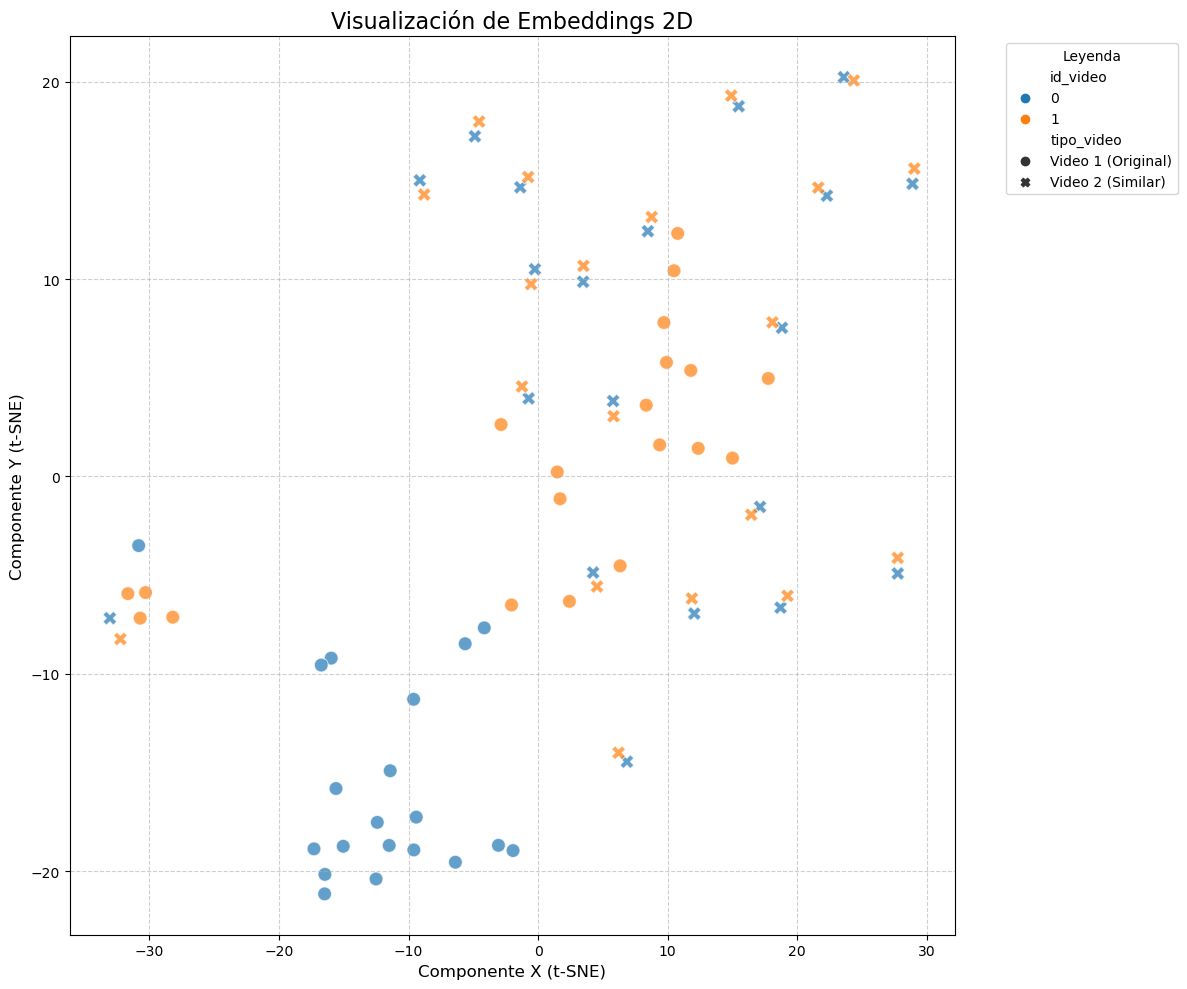

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...


2025-11-12 20:06:52,221 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.253s]
2025-11-12 20:06:52,234 - INFO - Use pytorch device_name: cpu
2025-11-12 20:06:52,235 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:06:53,925 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.007s]
2025-11-12 20:06:53,971 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]
2025-11-12 20:06:54,018 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]


  Video 1 (Original): D8VnI1UDvBo
  Video 2 (Similar):  wfaxvrOw7xk
--- Encontrados 20 comentarios para el video ID: D8VnI1UDvBo ---
--- Encontrados 20 comentarios para el video ID: wfaxvrOw7xk ---
Procesando tupla de grupo 1...


2025-11-12 20:06:54,294 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.235s]
2025-11-12 20:06:54,299 - INFO - Use pytorch device_name: cpu
2025-11-12 20:06:54,300 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:06:56,129 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.008s]
2025-11-12 20:06:56,174 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]
2025-11-12 20:06:56,231 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.014s]


  Video 1 (Original): Rd4LS_LgfPY
  Video 2 (Similar):  Ztc6QPNUqls
--- Encontrados 20 comentarios para el video ID: Rd4LS_LgfPY ---
--- Encontrados 20 comentarios para el video ID: Ztc6QPNUqls ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


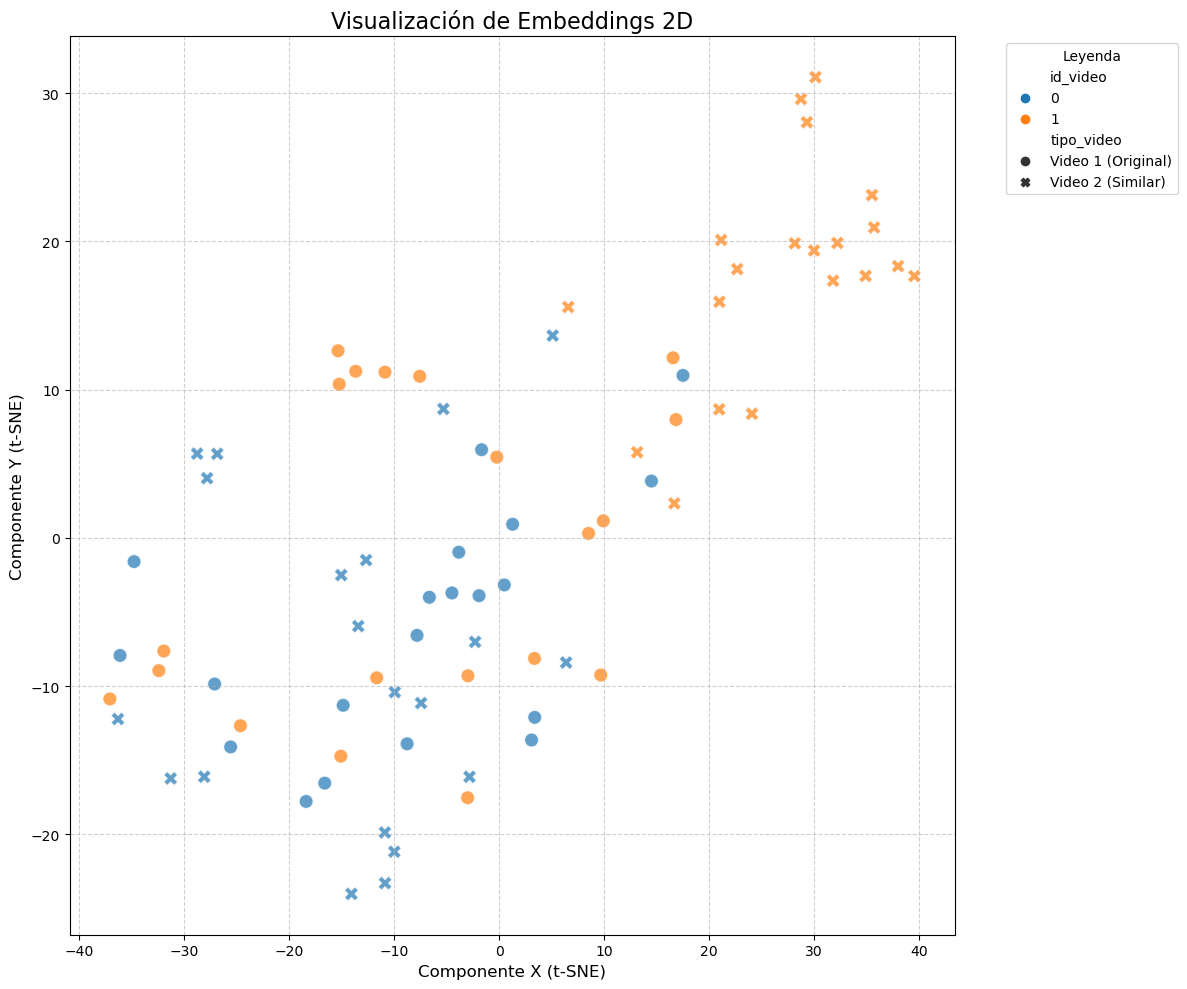

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...


2025-11-12 20:06:56,912 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.245s]
2025-11-12 20:06:56,918 - INFO - Use pytorch device_name: cpu
2025-11-12 20:06:56,918 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:06:58,739 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.008s]
2025-11-12 20:06:58,784 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.006s]
2025-11-12 20:06:58,824 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.004s]


  Video 1 (Original): NsRKKBSfZyY
  Video 2 (Similar):  Oiovhx_Vx4w
--- Encontrados 20 comentarios para el video ID: NsRKKBSfZyY ---
--- Encontrados 20 comentarios para el video ID: Oiovhx_Vx4w ---
Procesando tupla de grupo 1...


2025-11-12 20:06:59,088 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.229s]
2025-11-12 20:06:59,098 - INFO - Use pytorch device_name: cpu
2025-11-12 20:06:59,100 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:07:00,717 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.008s]
2025-11-12 20:07:00,752 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]
2025-11-12 20:07:00,789 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]


  Video 1 (Original): akNP9kfcWSs
  Video 2 (Similar):  Qe6o9j4IjTo
--- Encontrados 20 comentarios para el video ID: akNP9kfcWSs ---
--- Encontrados 20 comentarios para el video ID: Qe6o9j4IjTo ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


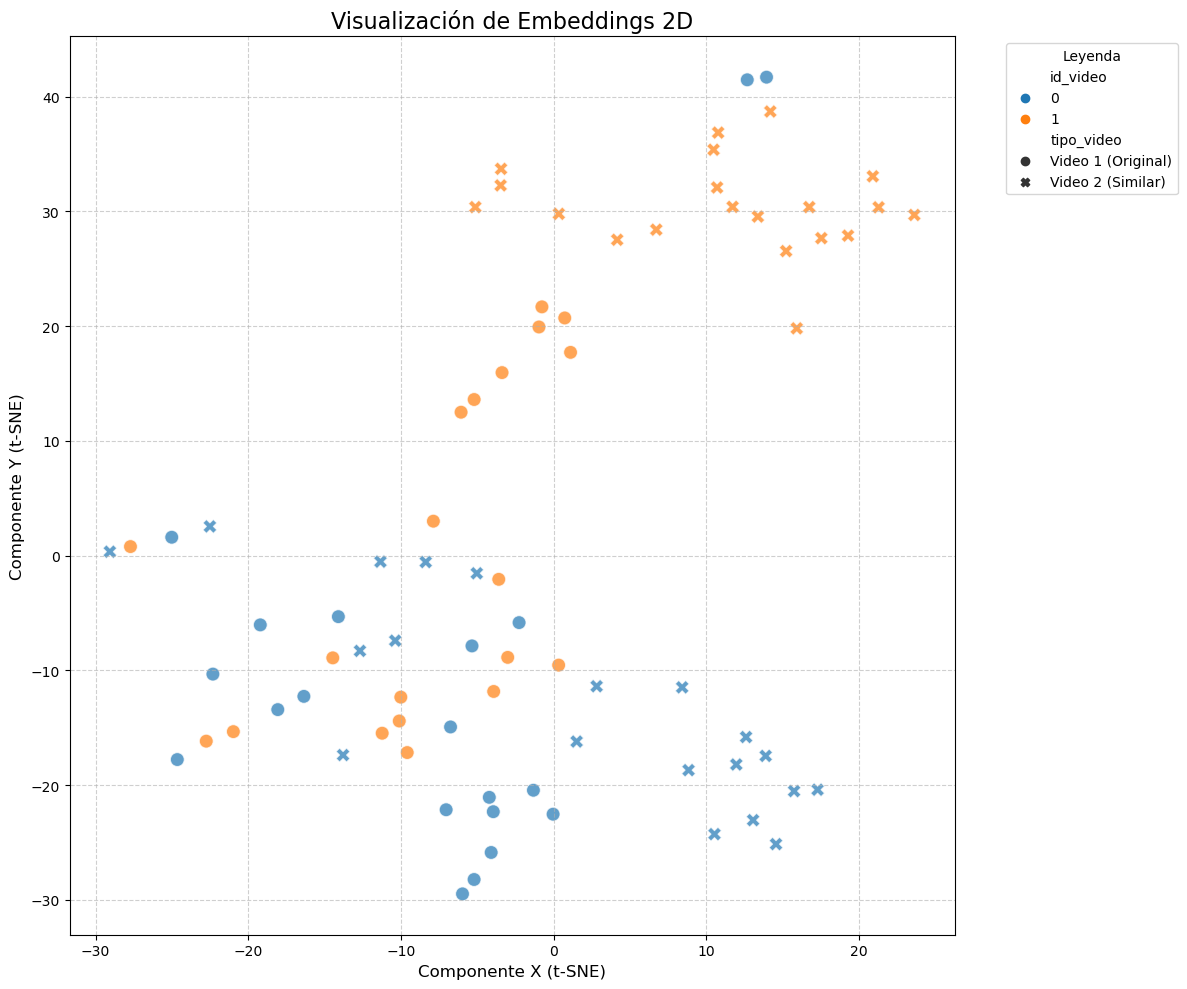

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...


2025-11-12 20:07:01,446 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.236s]
2025-11-12 20:07:01,452 - INFO - Use pytorch device_name: cpu
2025-11-12 20:07:01,452 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:07:03,086 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.008s]
2025-11-12 20:07:03,128 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.005s]
2025-11-12 20:07:03,176 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.013s]


  Video 1 (Original): GknU1yerGVQ
  Video 2 (Similar):  xdJwG_9kF8s
--- Encontrados 20 comentarios para el video ID: GknU1yerGVQ ---
--- Encontrados 20 comentarios para el video ID: xdJwG_9kF8s ---
Procesando tupla de grupo 1...


2025-11-12 20:07:03,459 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.249s]
2025-11-12 20:07:03,464 - INFO - Use pytorch device_name: cpu
2025-11-12 20:07:03,465 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-11-12 20:07:04,995 - INFO - POST http://elasticsearch:9200/videos/_search [status:200 duration:0.007s]
2025-11-12 20:07:05,030 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.004s]
2025-11-12 20:07:05,069 - INFO - POST http://elasticsearch:9200/comments/_search [status:200 duration:0.004s]


  Video 1 (Original): pY1jGcMGvnw
  Video 2 (Similar):  b3NxrZOu_CE
--- Encontrados 20 comentarios para el video ID: pY1jGcMGvnw ---
--- Encontrados 20 comentarios para el video ID: b3NxrZOu_CE ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


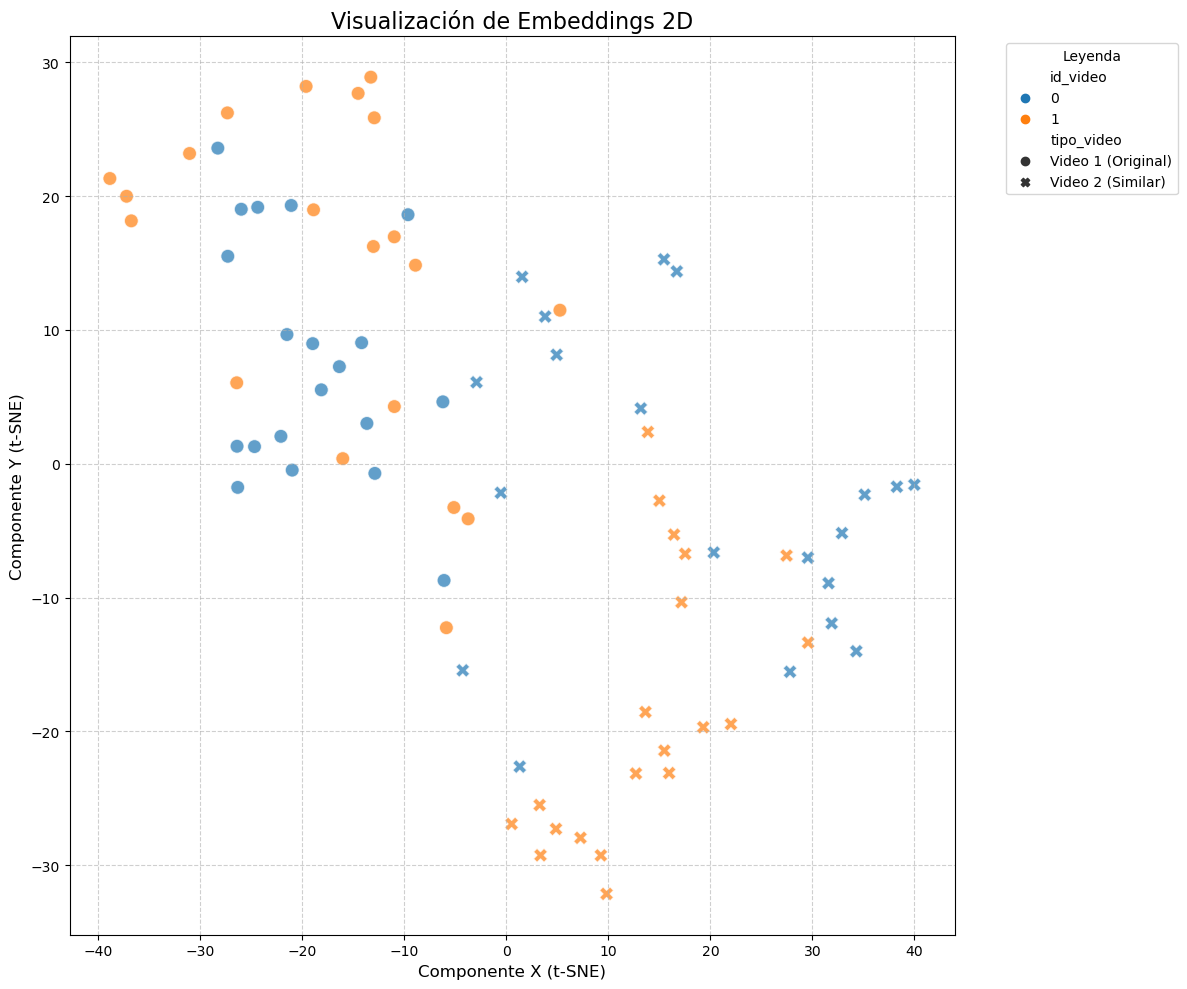

In [50]:
randomizers = [4, 16, 45, 120]
for randomizer in randomizers:
    df_para_graficar = compare_multiple_video_comments(es, n_tuples_of_videos_to_compare=2, id_video_randomizer=randomizer) 
    graficar_embeddings_2d(df=df_para_graficar, embedding_col='comment_emb2dims', color_col='id_video', style_col='tipo_video')

#### Exploración en DBPEDIA

Para visualizar los datos que hemos enlazado con dbpedia. 

In [52]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# URL del endpoint de tu repositorio en GraphDB
# Cambia 'nombre_repositorio' por el que tengas configurado en GraphDB
endpoint = "http://graphdb:7200/repositories/gestbd"

sparql = SPARQLWrapper(endpoint)
sparql.setReturnFormat(JSON)

# Ejemplo de consulta SPARQL para explorar con DBPedia
query = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbo: <http://dbpedia.org/ontology/>

SELECT DISTINCT ?canal ?sameAs ?p
WHERE {
  
    ?canal owl:sameAs ?sameAs .
    
 SERVICE <https://dbpedia.org/sparql>{
        ?sameAs ?p ?o
    }
}
"""

sparql.setQuery(query)
results = sparql.query().convert()

for result in results["results"]["bindings"]:
    print(result["canal"]["value"], result["sameAs"]["value"], result["p"]["value"])


http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://www.w3.org/2002/07/owl#sameAs
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://xmlns.com/foaf/0.1/name
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://www.w3.org/2000/01/rdf-schema#label
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://xmlns.com/foaf/0.1/homepage
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://dbpedia.org/property/name
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://xmlns.com/foaf/0.1/depiction
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw http://dbpedia.org/resource/3Blue1Brown http://ww

#### Exploración en Wikidata 

In [53]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX owl:  <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>

SELECT ?channel ?channelName ?wikidataEntity ?wdLabel ?wdDesc
WHERE {
  ?channel a wd:Q17558136 ;
           owl:sameAs ?wikidataEntity .
  OPTIONAL { ?channel schema:name ?channelName }

  SERVICE <https://query.wikidata.org/sparql> {
    ?wikidataEntity rdfs:label ?wdLabel .
    OPTIONAL { ?wikidataEntity schema:description ?wdDesc }
    FILTER(LANG(?wdLabel) = "en")
    FILTER(LANG(?wdDesc) = "en")
  }
}
LIMIT 50
"""

sparql.setQuery(query)
results = sparql.query().convert()

for result in results["results"]["bindings"]:
    print(result["channel"]["value"], "|", result["channelName"]["value"], "|", result["wikidataEntity"]["value"], "|", result["wdLabel"]["value"], "|", result["wdDesc"]["value"])

http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw | 3Blue1Brown | http://www.wikidata.org/entity/Q55345122 | 3Blue1Brown | YouTube channel that discusses mathematical concepts
http://gestdb.org/channel_UCJ0-OtVpF0wOKEqT2Z1HEtA | ElectroBOOM | http://www.wikidata.org/entity/Q47472219 | ElectroBOOM | YouTube channel
http://gestdb.org/channel_UC1_uAIS3r8Vu6JjXWvastJg | Mathologer | http://www.wikidata.org/entity/Q66565938 | Mathologer | YouTube channel on mathematics by Burkard Polster
http://gestdb.org/channel_UCHnyfMqiRRG1u-2MsSQLbXA | Veritasium | http://www.wikidata.org/entity/Q7921397 | Veritasium | YouTube channel created by Derek Muller
http://gestdb.org/channel_UC36xmz34q02JYaZYKrMwXng | Nate Gentile | http://www.wikidata.org/entity/Q111686858 | Nate Gentile | Uruguayan YouTuber
http://gestdb.org/channel_UCY1kMZp36IQSyNx_9h4mpCg | Mark Rober | http://www.wikidata.org/entity/Q24088544 | Mark Rober | American YouTuber, engineer and inventor


#### Comparación de consultas tipo OLTP


##### Top 20 videos ordered by total comentaries

In [54]:
query = """
PREFIX wd:  <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX schema: <http://schema.org/>

SELECT ?video ?title ?nComments ?channelName
WHERE {
  ?video a wd:Q63412991 ;          # vídeo
         wdt:P1476 ?title ;        # título
         wdt:P10651 ?nComments ;   # nº comentarios
         wdt:P123 ?channel .       # canal
  ?channel schema:name ?channelName .  # nombre del canal
}
ORDER BY DESC(?nComments)
LIMIT 20
"""

sparql.setQuery(query)
results = sparql.query().convert()

for result in results["results"]["bindings"]:
    print(result["video"]["value"], "|", result["title"]["value"], "|", result["nComments"]["value"], "|", result["channelName"]["value"])

http://gestdb.org/video_pTn6Ewhb27k | Why No One Has Measured The Speed Of Light | 115373 | Veritasium
http://gestdb.org/video_uxPdPpi5W4o | Why Are 96,000,000 Black Balls on This Reservoir? | 84811 | Veritasium
http://gestdb.org/video_bHIhgxav9LY | The Big Misconception About Electricity | 82905 | Veritasium
http://gestdb.org/video_094y1Z2wpJg | The Simplest Math Problem No One Can Solve - Collatz Conjecture | 80837 | Veritasium
http://gestdb.org/video_OxGsU8oIWjY | How An Infinite Hotel Ran Out Of Room | 79104 | Veritasium
http://gestdb.org/video_Grv1RJkdyqI | I Asked Bill Gates What's The Next Crisis? | 75784 | Veritasium
http://gestdb.org/video_W9tgtrWNFdc | Una Vídeo Respuesta a "DIOS EXISTE" | 65553 | QuantumFracture
http://gestdb.org/video_yCsgoLc_fzI | A Physics Prof Bet Me $10,000 I'm Wrong | 57786 | Veritasium
http://gestdb.org/video_YxELlBMP6W4 | Puedo Convencerte de que la Tierra es Plana | 55421 | QuantumFracture
http://gestdb.org/video_XRr1kaXKBsU | What Everyone Gets Wro

##### Número de videos por canal

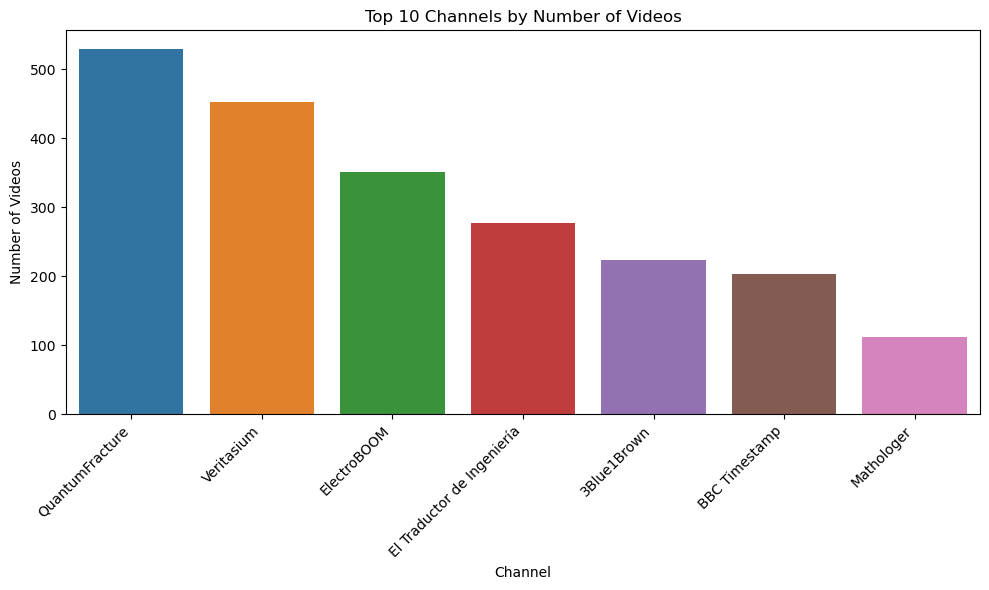

In [55]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

PREFIX schema: <http://schema.org/>
SELECT ?channelName (COUNT(?video) AS ?numVideos)
WHERE {
  ?video a wd:Q63412991 ;
         wdt:P123 ?channel .
  ?channel schema:name ?channelName .
}
GROUP BY ?channelName
ORDER BY DESC(?numVideos)
LIMIT 10
"""

sparql.setQuery(query)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
  channel_name = result["channelName"]["value"]
  num_videos = int(result["numVideos"]["value"])
  data.append({
    "Channel": channel_name,
    "NumVideos": num_videos
  })

df_videos_per_channel = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Channel", y="NumVideos", data=df_videos_per_channel)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Channel")
plt.ylabel("Number of Videos")
plt.title("Top 10 Channels by Number of Videos")
plt.tight_layout()
plt.show()

#### Consultas enlazadas con wikidata

##### Nacionalidad del Youtuber

In [56]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX owl:  <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT DISTINCT ?channel
				?channelName
       (COALESCE(?presenterLabel, ?wdLabel, ?prefLabel, ?schemaLabel, ?foafLabel) AS ?personName)
       (COALESCE(?presenterCountryLabel, ?citizenLabel) AS ?nationality)
WHERE {
  ?channel a wd:Q17558136 ;
           schema:name ?channelName ;
           owl:sameAs ?wikidataEntity .
  FILTER(STRSTARTS(STR(?wikidataEntity), "http://www.wikidata.org/entity/"))

  SERVICE <https://query.wikidata.org/sparql> {
    # Nombre del canal si es persona
    OPTIONAL { ?wikidataEntity rdfs:label ?wdLabel . FILTER(LANG(?wdLabel) IN ("en")) }

    # Nacionalidad si el canal es persona
    OPTIONAL {
      ?wikidataEntity wdt:P27 ?citizen .
      ?citizen rdfs:label ?citizenLabel .
      FILTER(LANG(?citizenLabel) IN ("en"))
    }

    # Presentador o creador con su país
    OPTIONAL {
      ?wikidataEntity (wdt:P371|wdt:P175|wdt:P170) ?presenter .
      ?presenter rdfs:label ?presenterLabel .
      FILTER(LANG(?presenterLabel) IN ("en"))
      OPTIONAL {
        ?presenter wdt:P27 ?presenterCountry .
        ?presenterCountry rdfs:label ?presenterCountryLabel .
        FILTER(LANG(?presenterCountryLabel) IN ("en"))
      }
    }
  }
}
ORDER BY ?personName
"""

sparql.setQuery(query)
results = sparql.query().convert()

for result in results["results"]["bindings"]:
    channel = result["channel"]["value"]
    channel_name = result["channelName"]["value"]
    person_name = result.get("personName", {}).get("value", "N/A")
    nationality = result.get("nationality", {}).get("value", "N/A")
    print(channel, "|", channel_name, "|", person_name, "|", nationality)

http://gestdb.org/channel_UCbdSYaPD-lr1kW27UJuk8Pw | QuantumFracture | N/A | Spain
http://gestdb.org/channel_UC1_uAIS3r8Vu6JjXWvastJg | Mathologer | Burkard Polster | Germany
http://gestdb.org/channel_UCHnyfMqiRRG1u-2MsSQLbXA | Veritasium | Derek Muller | Australia
http://gestdb.org/channel_UCYO_jab_esuFRV4b17AJtAw | 3Blue1Brown | Grant Sanderson | N/A
http://gestdb.org/channel_UCY1kMZp36IQSyNx_9h4mpCg | Mark Rober | Mark Rober | United States
http://gestdb.org/channel_UCJ0-OtVpF0wOKEqT2Z1HEtA | ElectroBOOM | Mehdi Sadaghdar | Canada
http://gestdb.org/channel_UCJ0-OtVpF0wOKEqT2Z1HEtA | ElectroBOOM | Mehdi Sadaghdar | Iran
http://gestdb.org/channel_UC36xmz34q02JYaZYKrMwXng | Nate Gentile | Nate Gentile | Uruguay


##### Número de subscriptores total agrupando por continente del que pertenece el Youtuber 

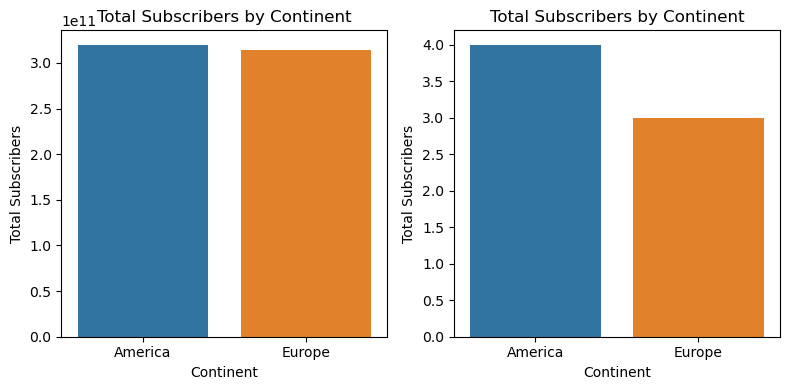

America | 4 | 319680890000
Europe | 3 | 314577040000


In [57]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX owl:  <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?continentGroup 
       (COUNT(DISTINCT ?channel) AS ?numChannels)
       (SUM(?subs) AS ?totalSubscribers)
WHERE {
  # --- Datos locales (canales) ---
  ?channel a wd:Q17558136 ;
           owl:sameAs ?wikidataEntity ;
           wdt:P3744 ?subs .          # Número de suscriptores (ajústalo si tu propiedad local es otra)
  FILTER(STRSTARTS(STR(?wikidataEntity), "http://www.wikidata.org/entity/"))

  # --- Enriquecimiento federado en Wikidata ---
  SERVICE <https://query.wikidata.org/sparql> {
    # País/nacionalidad del canal o de su presentador
    OPTIONAL { ?wikidataEntity wdt:P27 ?citizen . }      # Canal persona
    OPTIONAL { ?wikidataEntity (wdt:P17|wdt:P495|wdt:P159) ?country . }  # Canal organización

    # Presentador/creador
    OPTIONAL {
      ?wikidataEntity (wdt:P175|wdt:P371|wdt:P170) ?presenter .
      OPTIONAL { ?presenter wdt:P27 ?presenterCountry . }  # Nacionalidad del presentador
    }

    # Obtener un país final en orden de prioridad
    BIND(COALESCE(?presenterCountry, ?citizen, ?country) AS ?finalCountry)

    # Obtener el continente de ese país
    OPTIONAL { ?finalCountry wdt:P30 ?continent . }
  }

  # --- Clasificación del continente ---
  BIND(
    IF(?continent IN (wd:Q46, wd:Q458, wd:Q27468), "Europe",
      IF(?continent IN (wd:Q18, wd:Q49, wd:Q15, wd:Q538), "America", "Other")
    ) AS ?continentGroup
  )
  
  FILTER(?continentGroup IN ("Europe", "America"))
}
GROUP BY ?continentGroup
ORDER BY ?continentGroup
"""

sparql.setQuery(query)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
  continent = result["continentGroup"]["value"]
  num_channels = int(result["numChannels"]["value"])
  total_subs = int(result["totalSubscribers"]["value"])
  data.append({
    "Continent": continent,
    "Channels": num_channels,
    "Subscribers": total_subs
  })

df_subs = pd.DataFrame(data)

# Plot total subscribers by continent
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.barplot(x="Continent", y="Subscribers", data=df_subs)
plt.xlabel("Continent")
plt.ylabel("Total Subscribers")
plt.tight_layout()
plt.title("Total Subscribers by Continent")
plt.subplot(1, 2, 2)
sns.barplot(x="Continent", y="Channels", data=df_subs)
plt.xlabel("Continent")
plt.ylabel("Total Subscribers")
plt.title("Total Subscribers by Continent")
plt.tight_layout()
plt.show()

for result in results["results"]["bindings"]:
  print(result["continentGroup"]["value"], "|", result["numChannels"]["value"], "|", result["totalSubscribers"]["value"])

##### Video más popular de cada categoría en cada continente

In [58]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX owl:  <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>

SELECT ?continentGroup ?categoryName ?title ?channelName ?views
WHERE {
  # --- Video más visto por canal dentro de cada categoría ---
  {
    SELECT ?channel ?category (MAX(?views) AS ?maxViewsChannel)
    WHERE {
      ?video a wd:Q63412991 ;
        wdt:P123 ?channel ;    # canal al que pertenece
        wdt:P910 ?category ;   # categoría del vídeo
        wdt:P5436 ?views .     # número de visualizaciones
    }
    GROUP BY ?channel ?category
  }

  # --- Recuperar los vídeos que cumplen esas condiciones ---
  ?video a wd:Q63412991 ;
    wdt:P123 ?channel ;
    wdt:P910 ?category ;
    wdt:P5436 ?views ;
    wdt:P1476 ?title .
  FILTER(?views = ?maxViewsChannel)

  # --- Obtener el nombre local del canal y categoría ---
  OPTIONAL { ?category wdt:P1476 ?categoryName }
  FILTER(BOUND(?categoryName))

  ?channel schema:name ?channelName .

  # --- Canal enlazado con Wikidata ---
  ?channel owl:sameAs ?wikidataEntity .
  FILTER(STRSTARTS(STR(?wikidataEntity), "http://www.wikidata.org/entity/"))

  # --- Obtener país/continente del canal ---
  SERVICE <https://query.wikidata.org/sparql> {
    OPTIONAL { ?wikidataEntity wdt:P27 ?citizen . }
    OPTIONAL { ?wikidataEntity (wdt:P17|wdt:P495|wdt:P159) ?country . }
    OPTIONAL {
      ?wikidataEntity (wdt:P175|wdt:P371|wdt:P170) ?presenter .
      OPTIONAL { ?presenter wdt:P27 ?presenterCountry . }
    }
    BIND(COALESCE(?presenterCountry, ?citizen, ?country) AS ?finalCountry)
    OPTIONAL { ?finalCountry wdt:P30 ?continent . }
  }

  # --- Clasificación de continentes ---
  BIND(
    IF(?continent IN (wd:Q46, wd:Q458, wd:Q27468), "Europe",
      IF(?continent IN (wd:Q18, wd:Q49, wd:Q15, wd:Q538), "America", "Other")
    ) AS ?continentGroup
  )
  FILTER(?continentGroup IN ("Europe", "America"))
}

ORDER BY ?continentGroup ?categoryName ?channelName
"""

sparql.setQuery(query)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
  continent = result["continentGroup"].get("value", pd.NA)
  category = result["categoryName"].get("value", pd.NA)
  title = result["title"].get("value", pd.NA)
  channel = result["channelName"]["value"]
  views = int(result["views"]["value"])
  
  data.append({
    "Continent": continent,
    "Category": category,
    "Video": title,
    "Channel": channel,
    "Views": views
  })

df_videos = pd.DataFrame(data)
df_videos = df_videos[df_videos['Channel'] != '3Blue1Brown'].reset_index(drop=True)

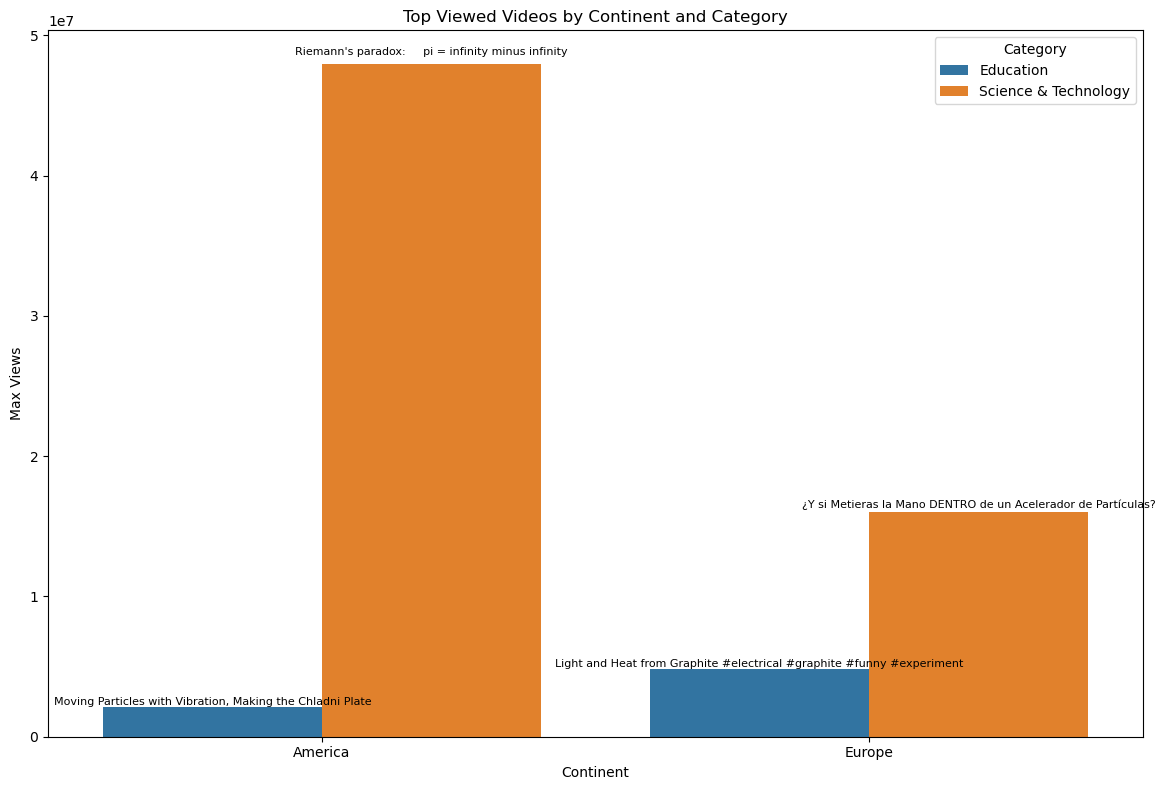

In [59]:
df_continent_summary = df_videos.groupby(['Continent', 'Category']).max().reset_index()

# Plot 
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Continent", y="Views", hue="Category", data=df_continent_summary)
plt.xlabel("Continent")
plt.ylabel("Max Views")
plt.title("Top Viewed Videos by Continent and Category")

# add the video titles on top of the bars
for bar, (_, row) in zip(ax.patches, df_continent_summary.iterrows()):
    height = bar.get_height()
    video_title = row['Video']
    ax.text(
        bar.get_x() + bar.get_width() / 2., 
        height + 0.01 * height, 
        video_title,
        ha="center", va="bottom", fontsize=8, rotation=0
    )

plt.tight_layout()
plt.show()

##### Ratio de Likes/Views ordenado por la fecha de nacimiento del Youtuber

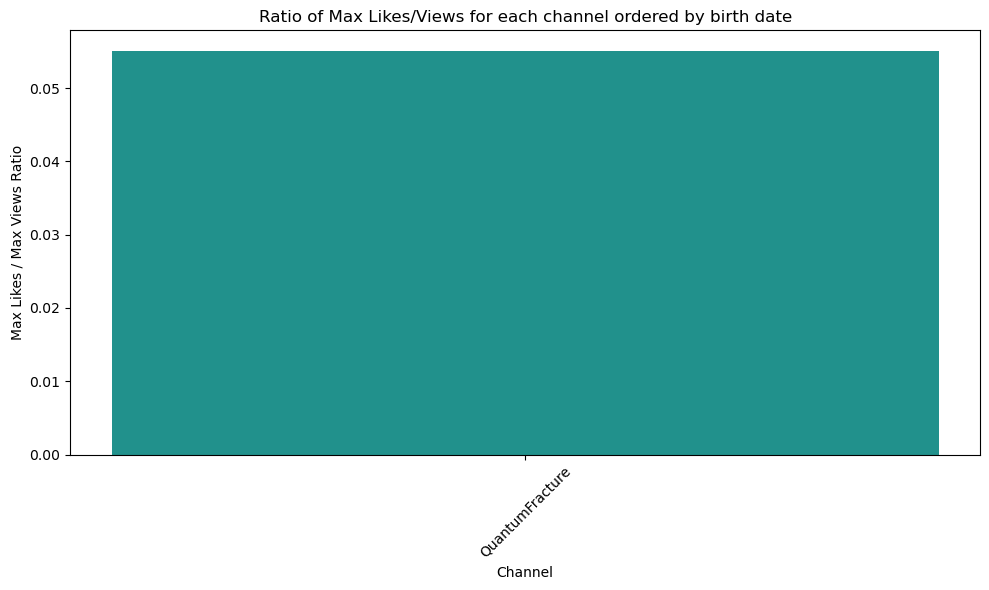

In [60]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX owl:  <http://www.w3.org/2002/07/owl#>
PREFIX schema: <http://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?channel ?channelName ?wikidataEntity ?birthDate ?maxViews ?maxLikes (?maxLikes/?maxViews as ?ratio)
WHERE {
  ?channel a wd:Q17558136 ;        # Canal de YouTube
           owl:sameAs ?wikidataEntity ;
           schema:name ?channelName .

  FILTER(STRSTARTS(STR(?wikidataEntity), "http://www.wikidata.org/entity/"))

  SERVICE <https://query.wikidata.org/sparql> {
    OPTIONAL { ?wikidataEntity wdt:P569 ?birthDate . }  # Fecha de nacimiento
  }
  {
    SELECT ?channel (MAX(?views) AS ?maxViews)
    WHERE {
      ?video a wd:Q63412991 ;        # Vídeo de YouTube
             wdt:P123 ?channel ;     # Propiedad canal (ajústala si es distinta)
             wdt:P5436 ?views .      # Número de visualizaciones
    }
    GROUP BY ?channel
    }
      {
    SELECT ?channel (MAX(?likes) AS ?maxLikes)
    WHERE {
      ?video a wd:Q63412991 ;        # Vídeo de YouTube
             wdt:P123 ?channel ;     # Propiedad canal (ajústala si es distinta)
             wdt:P10649 ?likes .      # Número de visualizaciones
    }
    GROUP BY ?channel
    }
}
ORDER BY ?birthDate"""

sparql.setQuery(query)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
  channel_name = result["channelName"]["value"]
  birth_date = result.get("birthDate", {}).get("value", pd.NA)
  max_views = int(result["maxViews"]["value"])
  max_likes = int(result["maxLikes"]["value"])
  ratio = float(result["ratio"]["value"])
  data.append({
    "Channel": channel_name,
    "BirthDate": birth_date,
    "MaxViews": max_views,
    "MaxLikes": max_likes,
    "Ratio": ratio
  })

df = pd.DataFrame(data)

df = df.dropna(subset=["BirthDate"])

# Plot Ratio vs Channel (ordered by birth date)
df_sorted = df.sort_values("BirthDate")
plt.figure(figsize=(10, 6))
plt.bar(df_sorted["Channel"], df_sorted["Ratio"], color=sns.color_palette("viridis", len(df_sorted)))
plt.xticks(rotation=45)
plt.xlabel("Channel")
plt.ylabel("Max Likes / Max Views Ratio")
plt.title("Ratio of Max Likes/Views for each channel ordered by birth date")
plt.tight_layout()
plt.show()

##### Universidades en las que ha estudiado cada Youtuber

In [61]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX owl:  <http://www.w3.org/2002/07/owl#>
PREFIX schema: <http://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?channel ?channelName ?wikidataEntity ?personName ?universityName
WHERE {
  # --- Canal enlazado a Wikidata ---
  ?channel a wd:Q17558136 ;
           schema:name ?channelName ;
           owl:sameAs ?wikidataEntity .
  FILTER(STRSTARTS(STR(?wikidataEntity), "http://www.wikidata.org/entity/"))

  # --- Bloque federado a Wikidata ---
  SERVICE <https://query.wikidata.org/sparql> {
    {
      # Caso: el canal es persona y tiene universidad directamente
      ?wikidataEntity wdt:P69 ?university .
      OPTIONAL { ?wikidataEntity rdfs:label ?personName . FILTER(LANG(?personName)="en") }
      ?university rdfs:label ?universityName .
      FILTER(LANG(?universityName)="en")
    }
    UNION
    {
      # Caso: el canal tiene creador/presentador/performer
      ?wikidataEntity (wdt:P175|wdt:P371|wdt:P170) ?person .
      OPTIONAL { ?person rdfs:label ?personName . FILTER(LANG(?personName)="en") }
      ?person wdt:P69 ?university .
      ?university rdfs:label ?universityName .
      FILTER(LANG(?universityName)="en")
    }
  }
}
ORDER BY ?channelName
"""

sparql.setQuery(query)
results = sparql.query().convert()

data = []
for result in results["results"]["bindings"]:
  channel_name = result["channelName"]["value"]
  person_name = result.get("personName", {}).get("value", pd.NA)
  university_name = result.get("universityName", {}).get("value", pd.NA)
  data.append({
    "Channel": channel_name,
    "Person": person_name,
    "University": university_name
  })

df = pd.DataFrame(data)

df = df.dropna(subset=["University"])
df = df.drop_duplicates()

df

,Channel,Person,University
0,3Blue1Brown,Grant Sanderson,Stanford University
1,ElectroBOOM,Mehdi Sadaghdar,University of Tehran
2,ElectroBOOM,Mehdi Sadaghdar,Simon Fraser University
3,Mark Rober,Mark Rober,Brigham Young University
4,Mark Rober,Mark Rober,University of Southern California
5,Mathologer,Burkard Polster,Friedrich-Alexander-Universität Erlangen-Nürnberg
6,QuantumFracture,<NA>,Autonomous University of Madrid
7,Veritasium,Derek Muller,Queen's University
8,Veritasium,Derek Muller,University of Sydney


##### Usuario de Twitter de cada Youtuber

In [62]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX owl:  <http://www.w3.org/2002/07/owl#>
PREFIX schema: <http://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?channel ?channelName ?wikidataEntity ?personName ?twitterHandle
WHERE {
  # --- Canal enlazado a Wikidata ---
  ?channel a wd:Q17558136 ;
           schema:name ?channelName ;
           owl:sameAs ?wikidataEntity .
  FILTER(STRSTARTS(STR(?wikidataEntity), "http://www.wikidata.org/entity/"))

  # ---Bloque federado: buscar Twitter del canal o de su creador ---
  SERVICE <https://query.wikidata.org/sparql> {
    {
      # Caso: el canal en sí tiene cuenta de Twitter
      OPTIONAL { ?wikidataEntity wdt:P2002 ?twitterHandle . }
      OPTIONAL { ?wikidataEntity rdfs:label ?personName . FILTER(LANG(?personName)="en") }
    }
    UNION
    {
      # Caso: el canal tiene un presentador o creador con Twitter
      ?wikidataEntity (wdt:P175|wdt:P371|wdt:P170) ?person .
      OPTIONAL { ?person wdt:P2002 ?twitterHandle . }
      OPTIONAL { ?person rdfs:label ?personName . FILTER(LANG(?personName)="en") }
    }
    FILTER(BOUND(?twitterHandle))
  }
}
ORDER BY ?channelName

"""

sparql.setQuery(query)
results = sparql.query().convert()

# Convert results to a DataFrame
data = []
for result in results["results"]["bindings"]:
  channel_name = result["channelName"]["value"]
  person_name = result.get("personName", {}).get("value", pd.NA)
  twitter_handle = result.get("twitterHandle", {}).get("value", pd.NA)
  data.append({
    "Channel": channel_name,
    "Person": person_name,
    "Twitter": twitter_handle
  })

df = pd.DataFrame(data)

df = df.drop_duplicates()

df

,Channel,Person,Twitter
0,3Blue1Brown,3Blue1Brown,3blue1brown
1,ElectroBOOM,Mehdi Sadaghdar,ElectroBOOMGuy
2,ElectroBOOM,Mehdi Sadaghdar,electroboomguy
3,Mark Rober,Mark Rober,MarkRober
4,Mathologer,Mathologer,mathologer
5,QuantumFracture,<NA>,QuantumFracture
6,Veritasium,Derek Muller,veritasium
7,Veritasium,Veritasium,veritasium
